# Edge Detection
Detect Signals in OAAM Functions Layer. Outputs polylines describing the connections. 

Conceptionally similar to scalable vertex detection. 

Tailored on the functions editor. Should be generalizable with medium effort. Expects vertical or horizontal line segments. Does not yet support crossings or other crossing solutions. Not tested for lines close to each other. Does not support diagonal lines, currently not a thing. Would be interesting with probabilistic Hough Trafo, but would probably need to subtract all other matches from the result. 

Maybe switch to template matching (with kind of same kernel/template). 

In [661]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import random as random

## Input

In [662]:
# Define the paths
# target_image_path = 'screenshot-3-tasks.PNG'
# target_image_path = 'door_system.png'
# target_image_path = 'door_system_after_preprocessing_big_padding.png' # version 2 for paper with scaled vertex
# target_image_path = 'door_system_after_preprocessing_big.png' # for other images
# target_image_path = 'system.png'
# target_image_path = 'crossing.png'
target_image_path = 'multiplecrossings.png'

target_img = cv2.imread(target_image_path)

#### Visualization of Input

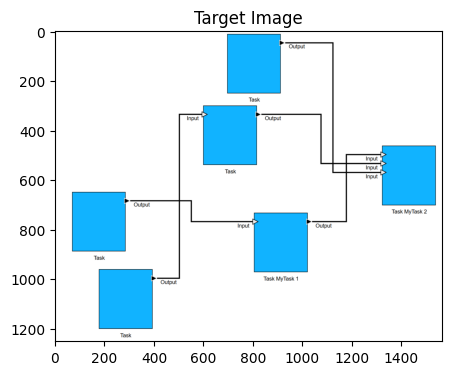

In [663]:
# Draw target image
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
ax.set_title('Target Image')
plt.show()

## Grayscale
Grayscale is enough here. Kernel methods are not really for multi channel images. 

In [664]:
# Convert to grayscale
target_gray = cv2.cvtColor(target_img, cv2.COLOR_BGR2GRAY)

#### Visualize Grayscale

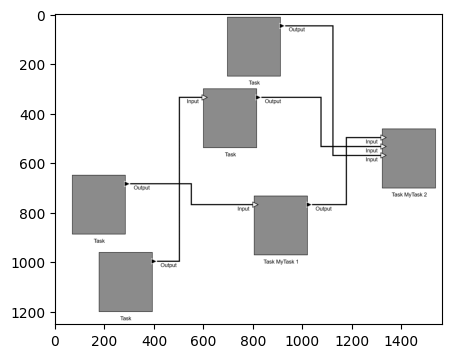

In [665]:
# Draw it
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(target_gray, cmap='gray')
plt.show()

## Kernel / Custom Filter

#### Kernel Custom Line Detection Kernel
idea for later: search for many thicknesses of lines

In [666]:
# Define custom kernels
kernel_vertical = np.tile(np.array([[1, 1, 0, -1, -1, -1, -1, 0, 1, 1]], dtype=np.float32), (5, 1))
kernel_horizontal = np.transpose(kernel_vertical)

In [667]:
kernel_cross= np.ones((12, 12))

kernel_cross[3:9, 0:12] = 0.5  # Left vertical outline
kernel_cross[0:12, 3:9] = 0.5  # Right vertical outline

kernel_cross[4:8, 0:12] = 0  # Vertical part of the cross
kernel_cross[0:12, 4:8] = 0  # Horizontal part of the cross

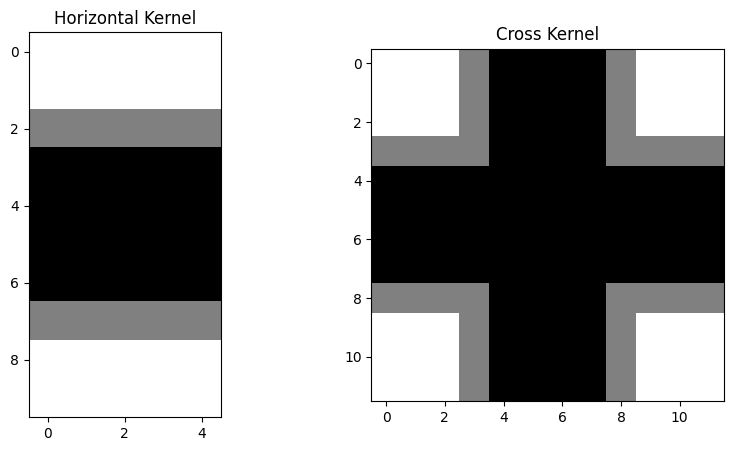

In [668]:
# Draw the kernel
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(kernel_horizontal, cmap='gray')
ax[0].set_title('Horizontal Kernel')
ax[1].imshow(kernel_cross, cmap='gray')
ax[1].set_title('Cross Kernel')
plt.show()
# Save the cross kernel as a 10 by 10 pixel .png
# kernel_cross_resized = cv2.resize(kernel_cross, (10, 10), interpolation=cv2.INTER_NEAREST)
# cv2.imwrite('cross_kernel.png', (kernel_cross * 255).astype(np.uint8))

#### Kerneling

In [669]:
# Apply custom filter
result_filter_ver = cv2.filter2D(target_gray, cv2.CV_32F, kernel_vertical)
result_filter_hor = cv2.filter2D(target_gray, cv2.CV_32F, kernel_horizontal)
result_filter_crs = cv2.filter2D(target_gray, cv2.CV_32F, kernel_cross)

#### Visualize Kernel Results

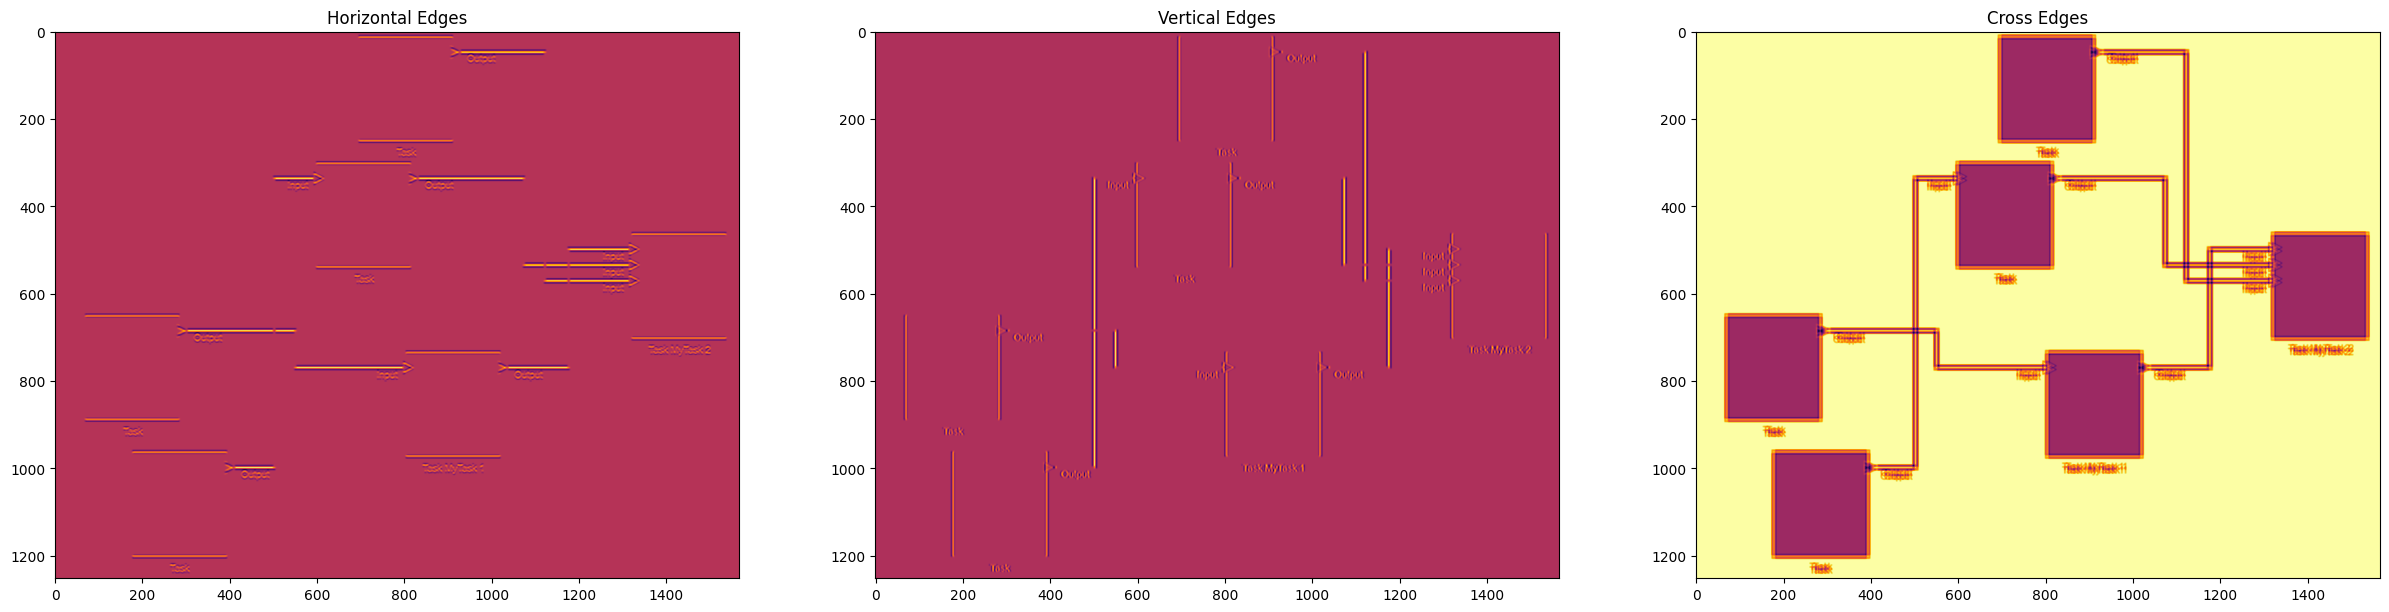

In [670]:
# Draw the horizontal, vertical, and cross edges
fig, ax = plt.subplots(1, 3, figsize=(30, 20))
ax[0].imshow(result_filter_hor, cmap='inferno')
ax[0].set_title('Horizontal Edges')
ax[1].imshow(result_filter_ver, cmap='inferno')
ax[1].set_title('Vertical Edges')
ax[2].imshow(result_filter_crs, cmap='inferno')
ax[2].set_title('Cross Edges')
plt.show()

Cross kernel seems not to work, new algorythm using template matching is used later in the code

#### Visualization of Filter over Target Image

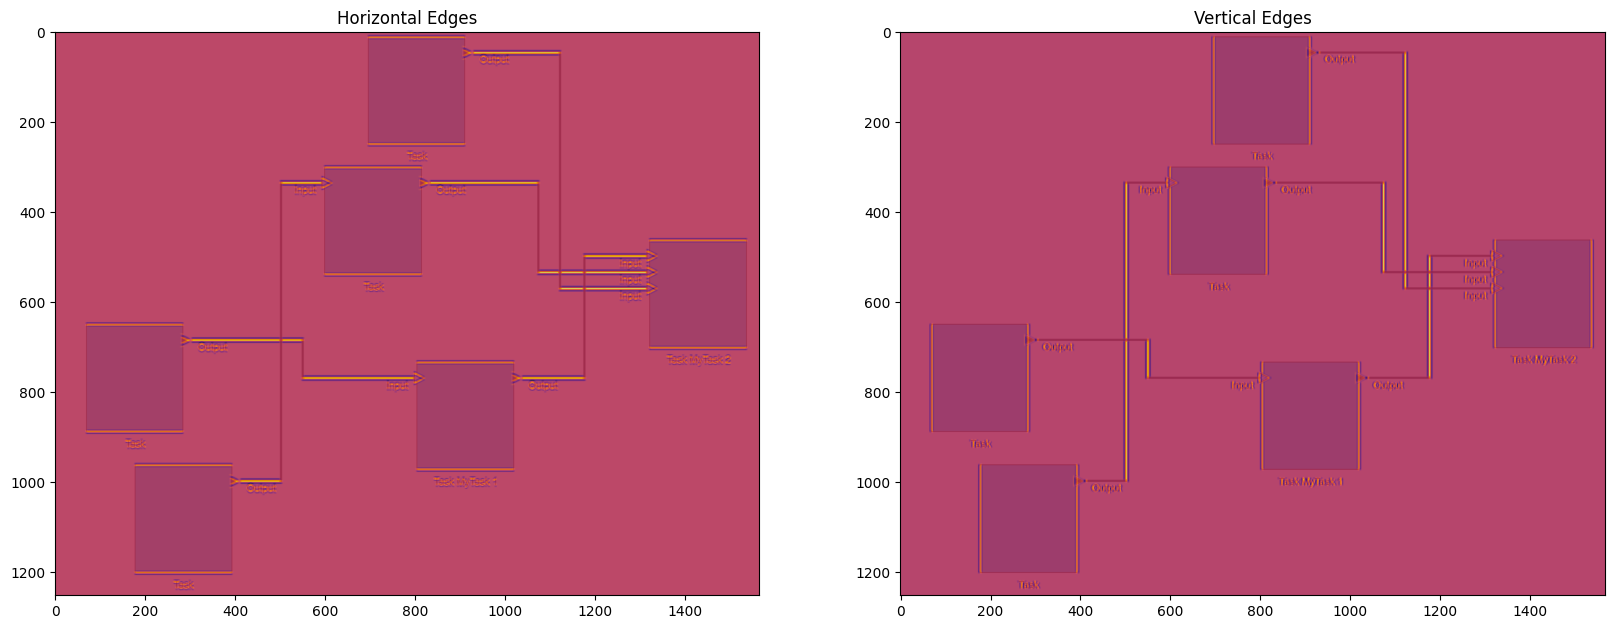

In [671]:
# Overlay both heatmaps on the target image
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
ax[0].imshow(result_filter_hor, cmap='inferno', alpha=0.9)
ax[0].set_title('Horizontal Edges')
ax[1].imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
ax[1].imshow(result_filter_ver, cmap='inferno', alpha=0.9)
ax[1].set_title('Vertical Edges')
plt.show()

#### Histogram

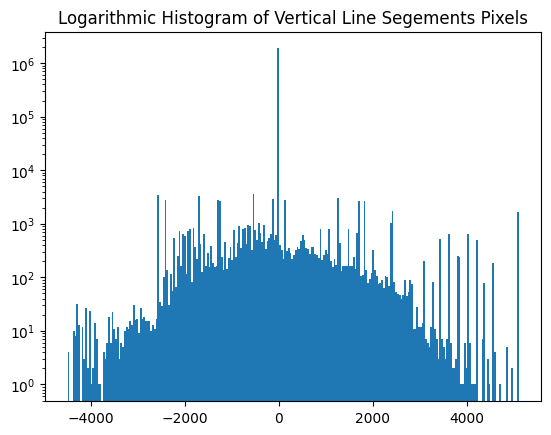

In [672]:
# Draw a logarithmic histogram of vertical edges
plt.hist(result_filter_ver.ravel(), bins=256, log=True)
plt.title('Logarithmic Histogram of Vertical Line Segements Pixels')
plt.show()

#### Visualization of Custom Filter 3D with plotly

In [673]:
activate_plotly = False
if activate_plotly:
    # Create a 3D surface plot of the vertical edges
    fig = go.Figure(data=[go.Surface(z=result_filter_ver)])
    # fig = go.Figure(data=[go.Surface(z=result_filter_hor)])  # Horizontal edges
    fig.update_layout(
        title='3D Surface Plot of Vertical Edges',
        height=1500,
        scene=dict(
            yaxis = dict(autorange='reversed'),
            )
        )
    fig.show()


#### Visualization of Custom Filter 3D with plotly with screenshot for paper

In [674]:
template_matching_result = result_filter_hor.copy()

# target image
activate_plotly = False
if activate_plotly:
  fig = go.Figure()

  # Layer 1: 3D Plot of Heatmap
  fig.add_trace(go.Surface(
    z = template_matching_result,
    showscale = False
  ))

  # Layer 2: 2D Plot of Target Image at 1000
  z_image = np.ones_like(target_gray) * 1000
  fig.add_trace(go.Surface(
    z = z_image,
    showscale = False,
    # opacity = 0.5,
    surfacecolor = target_gray,
    colorscale = 'gray',
  ))

  fig.update_layout(title='Heatmap Custom Filter Vertical Edges', 
                    scene=dict(
                    yaxis=dict(autorange='reversed') 
                    ),
                    height=1500,
                    scene_aspectratio=dict(x=2, y=1, z=0.2),
                    )

  fig.show()

#### Normalizing to 8 Bit

In [675]:
# Normalize to 0-255 and convert to uint8
result_filter_ver_norm = cv2.normalize(result_filter_ver, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
result_filter_hor_norm = cv2.normalize(result_filter_hor, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)


#### Check Histogram

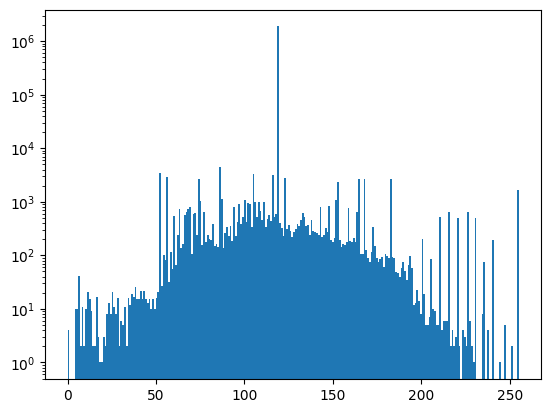

In [676]:
# plot the histogram of the normalized vertical edges, log scale
plt.hist(result_filter_ver_norm.ravel(), 256, log=True)
plt.show()
# histogram looks like above, but with other scale -> what we want

#### 8Bit 3D Plot Plotly

In [677]:
activate_plotly = False
if activate_plotly:
    # Create a 3D surface plot of the vertical edges
    fig = go.Figure(data=[go.Surface(z=result_filter_ver_norm)])
    # fig = go.Figure(data=[go.Surface(z=result_filter_hor_norm)])  # Horizontal edges
    fig.update_layout(
        title='3D Surface Plot of Vertical Edges, Normalized 8Bit',
        height=1500,
        scene=dict(
            yaxis = dict(autorange='reversed'),
            )
        )
    fig.show()

#### Thresholding

In [678]:
threshold = 220
_, result_filter_ver_thresh = cv2.threshold(result_filter_ver_norm, threshold, 255, cv2.THRESH_BINARY)
_, result_filter_hor_thresh = cv2.threshold(result_filter_hor_norm, threshold, 255, cv2.THRESH_BINARY)

#### Visualize Thresholding

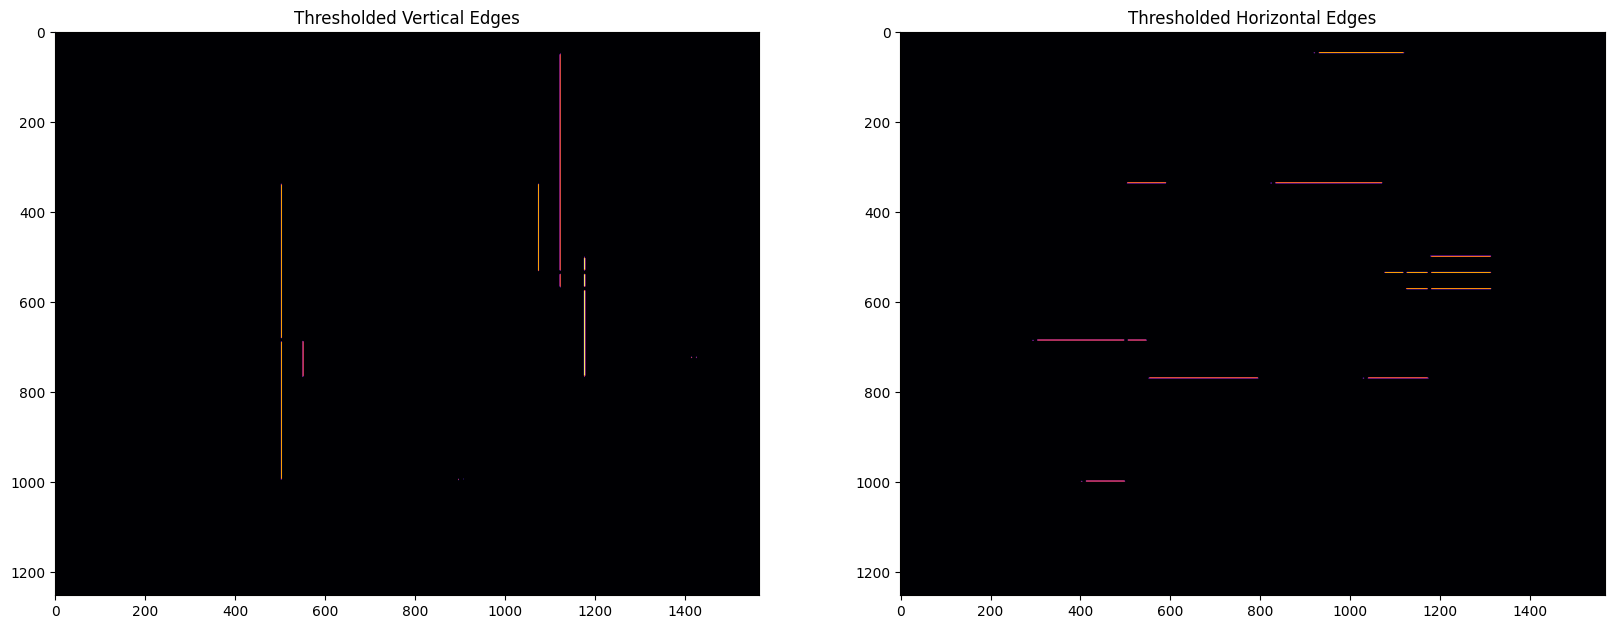

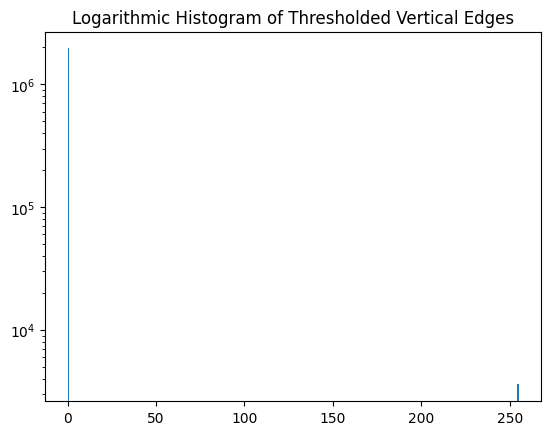

In [679]:
# Draw the thresholded images next to each other
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(result_filter_ver_thresh, cmap='inferno')
ax[0].set_title('Thresholded Vertical Edges')
ax[1].imshow(result_filter_hor_thresh, cmap='inferno')
ax[1].set_title('Thresholded Horizontal Edges')
plt.show()

# it is a binary image, even if it does not look like this!!!

# Draw a logarithmic histogram of thresholded vertical edges
plt.hist(result_filter_ver_thresh.ravel(), bins=256, log=True)
plt.title('Logarithmic Histogram of Thresholded Vertical Edges')
plt.show()

### 2D with Plotly

In [680]:
# plot vertical thresholded 8Bit edges 2D plotly
activate_plotly = False
if activate_plotly:
    fig = go.Figure()
    
    # Only Layer: Heatmap
    fig.add_trace(go.Heatmap(
        z = result_filter_hor_thresh,
        colorscale = 'inferno',
        showscale = False
    ))

    fig.update_layout(title='Thresholded Vertical Edges 8Bit',
                        height=1200,
                        yaxis=dict(autorange='reversed'),
                        )
    fig.show()

## Combine Horizontal + Vertical

In [681]:
# Superposition thresholded vertical edges and horizontal edges
hv_edges_thresh = result_filter_ver_thresh + result_filter_hor_thresh

#### Draw Horizontal and Vertical Edges Together

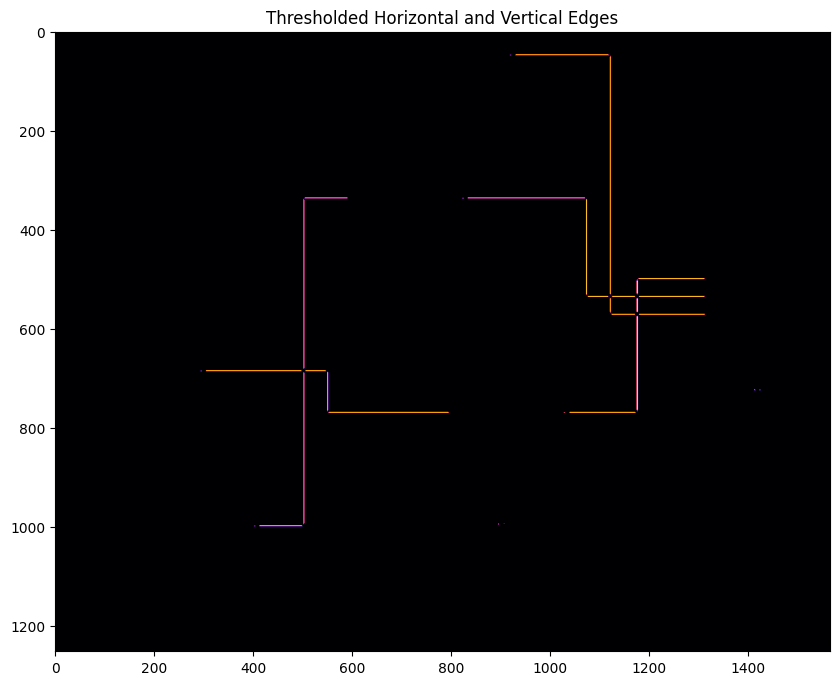

In [682]:
# Draw the sum
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(hv_edges_thresh, cmap='inferno')
# again, it is a binary image, even if it does not look like this!!!
ax.set_title('Thresholded Horizontal and Vertical Edges')
plt.show()

#### Overlay on Target Image

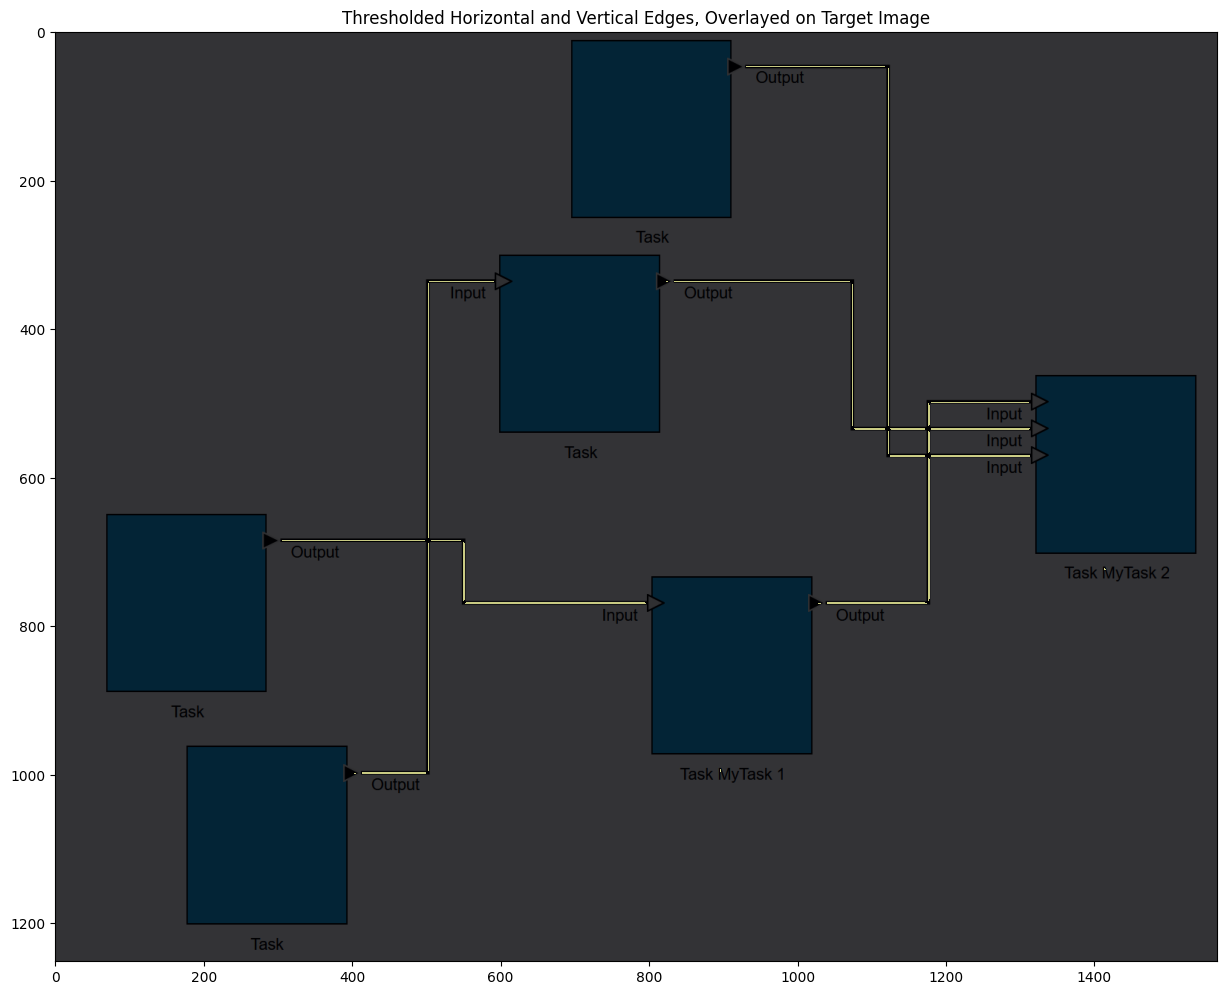

In [683]:
# Overlay the heatmap on the original image
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
ax.imshow(hv_edges_thresh, cmap='inferno', alpha=0.8, interpolation='nearest')  # `alpha` controls the transparency.
plt.title('Thresholded Horizontal and Vertical Edges, Overlayed on Target Image')
plt.show()

#### 2D big Xes on Target Image



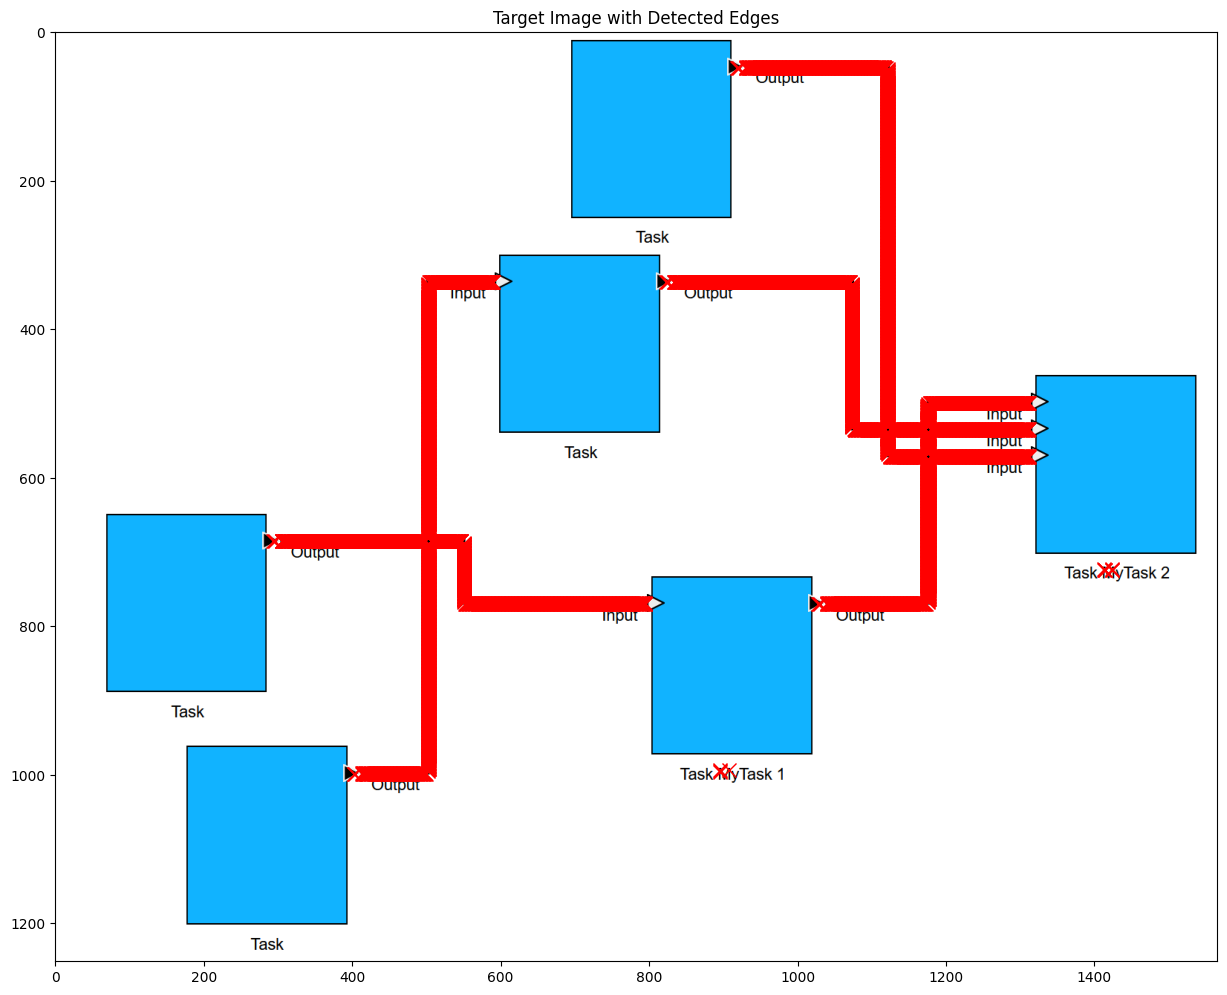

Number of detected edge pixels: 7105


In [684]:
# plot over the target image the hv_edges_thresh. For every that is not 0, plot a big red X

# Draw the target image as a background
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))

# Get the coordinates of the non-zero pixels
nonzero_coords = np.argwhere(hv_edges_thresh) # argwhere searches for non-zero elements

# Plot a big red X for each non-zero pixel
for y, x in nonzero_coords:
    ax.plot(x, y, 'rx', markersize=10)

plt.title('Target Image with Detected Edges')
plt.show()

# print number of non-zero pixels
print(f'Number of detected edge pixels: {len(nonzero_coords)}')

## From Pixels to Contours

#### Group Pixels to Contours

In [685]:
# Find contours
contours_hor, _ = cv2.findContours(result_filter_hor_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours_ver, _ = cv2.findContours(result_filter_ver_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f'Found {len(contours_hor)} horizontal contours, and {len(contours_ver)} vertical contours')

# Print the contour points
for i, contour in enumerate(contours_hor):
    print(f"Horizontal contour {i}: {contour.squeeze().tolist()}")
for i, contour in enumerate(contours_ver):
    print(f"Vertical contour {i}: {contour.squeeze().tolist()}")

Found 19 horizontal contours, and 13 vertical contours
Horizontal contour 0: [[402, 999], [404, 999]]
Horizontal contour 1: [[413, 998], [413, 999], [499, 999], [498, 998]]
Horizontal contour 2: [[1028, 770], [1030, 770]]
Horizontal contour 3: [[1040, 769], [1039, 770], [1173, 770], [1172, 770], [1171, 769]]
Horizontal contour 4: [[554, 769], [553, 770], [552, 770], [795, 770], [794, 769]]
Horizontal contour 5: [[294, 686], [296, 686]]
Horizontal contour 6: [[506, 685], [506, 686], [547, 686], [546, 685]]
Horizontal contour 7: [[305, 685], [305, 686], [497, 686], [497, 685]]
Horizontal contour 8: [[1180, 571], [1180, 572], [1312, 572], [1312, 571]]
Horizontal contour 9: [[1124, 571], [1125, 572], [1171, 572], [1171, 571]]
Horizontal contour 10: [[1180, 535], [1180, 536], [1311, 536], [1312, 535]]
Horizontal contour 11: [[1125, 535], [1126, 536], [1171, 536], [1171, 535]]
Horizontal contour 12: [[1076, 535], [1077, 536], [1117, 536], [1117, 535]]
Horizontal contour 13: [[1178, 499], [11

#### Plot all Contours

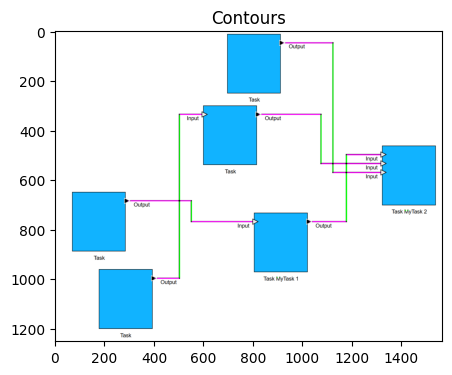

In [686]:
# Draw the contours. Horizontal in blue, vertical in green
contour_img_all = target_img.copy()
# Convert contours to the correct format
contours_hor = [np.array(contour, dtype=np.int32) for contour in contours_hor]
contours_ver = [np.array(contour, dtype=np.int32) for contour in contours_ver]

# Draw contours
cv2.drawContours(contour_img_all, contours_hor, -1, (255, 0, 255), 2)
cv2.drawContours(contour_img_all, contours_ver, -1, (0, 255, 0), 2)

# Plot the contours
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(cv2.cvtColor(contour_img_all, cv2.COLOR_BGR2RGB))
ax.set_title('Contours')
plt.show()

#### Filter out very short Contours
thes are mainly false positives, for example at the ports.
They are very hard to see.

In [687]:
# Filter out very short contours
min_contour_length = 20
contours_hor_filtered = [c for c in contours_hor if cv2.arcLength(c, False) > min_contour_length]
contours_ver_filtered = [c for c in contours_ver if cv2.arcLength(c, False) > min_contour_length]
print(f'After filtering, found {len(contours_hor_filtered)} horizontal contours, and {len(contours_ver_filtered)} vertical contours.')
print(f'Filtered out {len(contours_hor) - len(contours_hor_filtered)} horizontal contours, and {len(contours_ver) - len(contours_ver_filtered)} vertical contours.')

# Print the points of the filtered contours
for i, contour in enumerate(contours_hor_filtered):
    print(f"Horizontal contour {i}: {contour.squeeze().tolist()}")
for i, contour in enumerate(contours_ver_filtered):
    print(f"Vertical contour {i}: {contour.squeeze().tolist()}")

After filtering, found 14 horizontal contours, and 9 vertical contours.
Filtered out 5 horizontal contours, and 4 vertical contours.
Horizontal contour 0: [[413, 998], [413, 999], [499, 999], [498, 998]]
Horizontal contour 1: [[1040, 769], [1039, 770], [1173, 770], [1172, 770], [1171, 769]]
Horizontal contour 2: [[554, 769], [553, 770], [552, 770], [795, 770], [794, 769]]
Horizontal contour 3: [[506, 685], [506, 686], [547, 686], [546, 685]]
Horizontal contour 4: [[305, 685], [305, 686], [497, 686], [497, 685]]
Horizontal contour 5: [[1180, 571], [1180, 572], [1312, 572], [1312, 571]]
Horizontal contour 6: [[1124, 571], [1125, 572], [1171, 572], [1171, 571]]
Horizontal contour 7: [[1180, 535], [1180, 536], [1311, 536], [1312, 535]]
Horizontal contour 8: [[1125, 535], [1126, 536], [1171, 536], [1171, 535]]
Horizontal contour 9: [[1076, 535], [1077, 536], [1117, 536], [1117, 535]]
Horizontal contour 10: [[1178, 499], [1179, 499], [1180, 500], [1311, 500], [1312, 499]]
Horizontal contour 

#### Print and Plot the Contours

Contour horizontal: 0, Length: 88.4, Points: [[413, 998], [413, 999], [499, 999], [498, 998]]
Contour horizontal: 1, Length: 137.8, Points: [[1040, 769], [1039, 770], [1173, 770], [1172, 770], [1171, 769]]
Contour horizontal: 2, Length: 246.8, Points: [[554, 769], [553, 770], [552, 770], [795, 770], [794, 769]]
Contour horizontal: 3, Length: 43.4, Points: [[506, 685], [506, 686], [547, 686], [546, 685]]
Contour horizontal: 4, Length: 194.0, Points: [[305, 685], [305, 686], [497, 686], [497, 685]]
Contour horizontal: 5, Length: 134.0, Points: [[1180, 571], [1180, 572], [1312, 572], [1312, 571]]
Contour horizontal: 6, Length: 48.4, Points: [[1124, 571], [1125, 572], [1171, 572], [1171, 571]]
Contour horizontal: 7, Length: 133.4, Points: [[1180, 535], [1180, 536], [1311, 536], [1312, 535]]
Contour horizontal: 8, Length: 47.4, Points: [[1125, 535], [1126, 536], [1171, 536], [1171, 535]]
Contour horizontal: 9, Length: 42.4, Points: [[1076, 535], [1077, 536], [1117, 536], [1117, 535]]
Contou

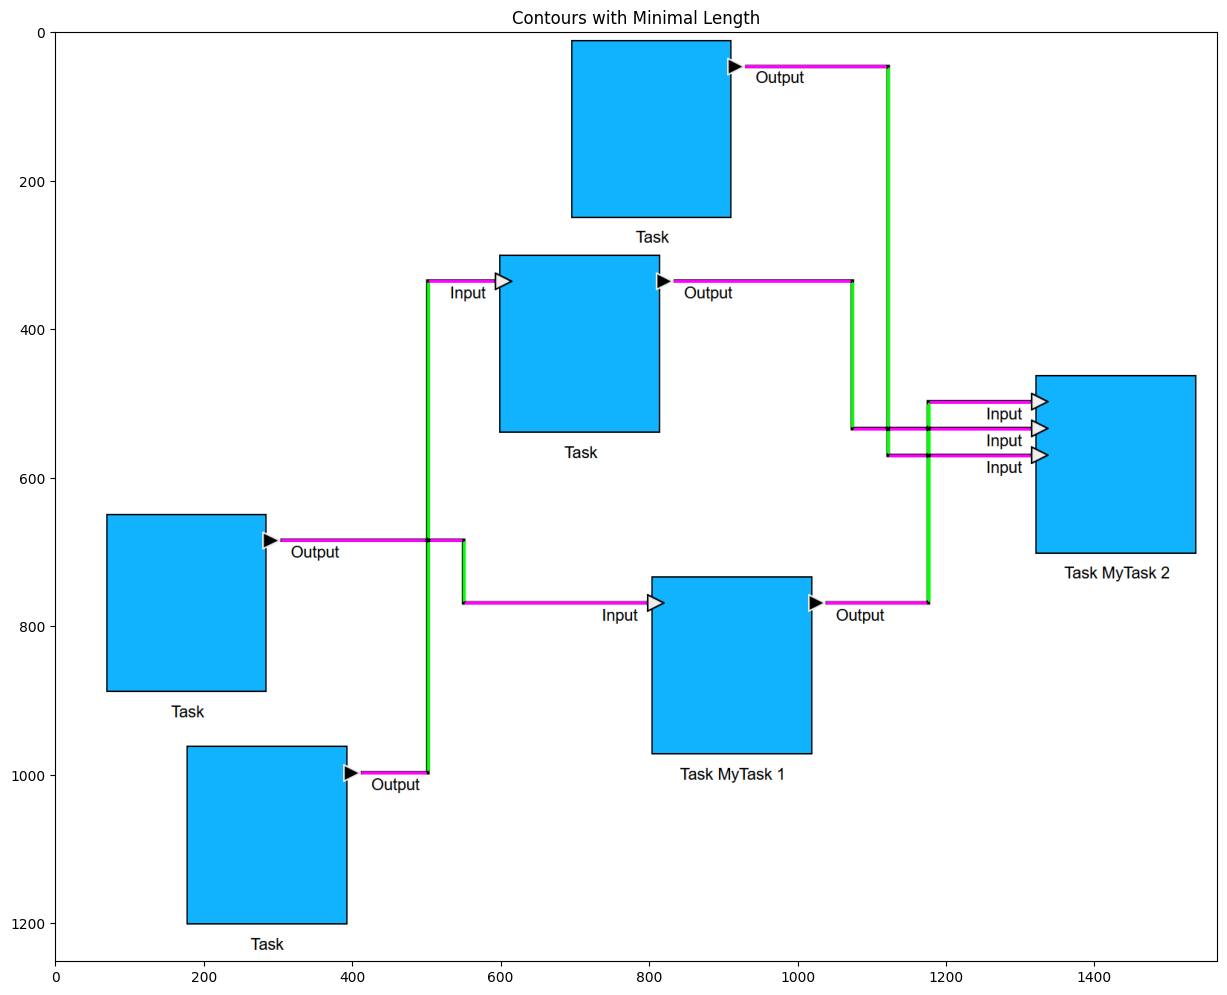

In [688]:
# Print the contours
for i, c in enumerate(contours_hor_filtered):
    print(f"Contour horizontal: {i}, Length: {cv2.arcLength(c, False):.1f}, Points: {c.squeeze().tolist()}")
for i, c in enumerate(contours_ver_filtered):
    print(f"Contour vertical: {i}, Length: {cv2.arcLength(c, False):.1f}, Points: {c.squeeze().tolist()}")

# Draw the contours. Horizontal in blue, vertical in green
contour_img = target_img.copy()
cv2.drawContours(contour_img, contours_hor_filtered, -1, (255, 0, 255), 2)
cv2.drawContours(contour_img, contours_ver_filtered, -1, (0, 255, 0), 2)

# Plot the contours
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
ax.set_title('Contours with Minimal Length')
plt.show()
# Create a very large blank image
large_img = np.zeros((2000, 2000, 3), dtype=np.uint8)

plt.show()

## From Contours to Line Segments
Contours are areas (but very line segment looking). So they are approximated to line segments.

In [689]:
def vertical_contours_to_vertical_segments(contours):
    """
    Convert vertical contours to vertical line segments.

    Parameters:
    - contours: List of contours, where each contour is an array of points.

    Returns:
    - lines: List of tuples representing vertical line segments ((x, y1), (x, y2)).
    """
    lines = []
    for contour in contours:
        # Simplify contour to ensure it's processed as a line if it's not already
        simplified_contour = cv2.approxPolyDP(contour, epsilon=0.5, closed=False)

        # Extract the vertical extents by finding min and max y coordinates
        x_coords = simplified_contour[:, :, 0]
        y_coords = simplified_contour[:, :, 1]
        
        y1, y2 = np.min(y_coords), np.max(y_coords)
        x = np.mean(x_coords).astype(int)  # Assuming vertical, x should be constant
        
        lines.append(((x, y1), (x, y2)))
    
    return lines

line_segments_ver = vertical_contours_to_vertical_segments(contours_ver_filtered)
for i, line in enumerate(line_segments_ver):
    print(f"Vertical line segment {i}: Start: ({line[0][0]}, {line[0][1]}), End: ({line[1][0]}, {line[1][1]})")

Vertical line segment 0: Start: (502, 689), End: (502, 995)
Vertical line segment 1: Start: (550, 688), End: (550, 767)
Vertical line segment 2: Start: (1176, 575), End: (1176, 767)
Vertical line segment 3: Start: (1176, 539), End: (1176, 567)
Vertical line segment 4: Start: (1121, 539), End: (1121, 568)
Vertical line segment 5: Start: (1176, 501), End: (1176, 531)
Vertical line segment 6: Start: (1073, 339), End: (1073, 532)
Vertical line segment 7: Start: (502, 339), End: (502, 681)
Vertical line segment 8: Start: (1121, 50), End: (1121, 531)


In [690]:
def horizontal_contours_to_horizontal_segments(contours):
    """
    Convert horizontal contours to horizontal line segments.

    Parameters:
    - contours: List of contours, where each contour is an array of points.

    Returns:
    - lines: List of tuples representing horizontal line segments ((x1, y), (x2, y)).
    """
    lines = []
    for contour in contours:
        # Simplify contour to ensure it's processed as a line if it's not already
        # print(f"contour: {contour.squeeze().tolist()}")
        simplified_contour = cv2.approxPolyDP(contour, epsilon=3, closed=False)
        # print(f"simplified_contour: {simplified_contour.squeeze().tolist()}")
        
        # Extract the horizontal extents by finding min and max x coordinates
        x_coords = simplified_contour[:, :, 0]
        # print(f"x_coords: {x_coords.squeeze().tolist()}")
        y_coords = simplified_contour[:, :, 1]
        # print(f"y_coords: {y_coords.squeeze().tolist()}")
        
        x1, x2 = np.min(x_coords), np.max(x_coords)
        y = np.mean(y_coords).astype(int)  # Assuming horizontal, y should be constant
        
        lines.append(((x1, y), (x2, y)))
    
    return lines

line_segments_hor = horizontal_contours_to_horizontal_segments(contours_hor_filtered)
for i, line in enumerate(line_segments_hor):
    print(f"Horizontal line segment {i}: Start: ({line[0][0]}, {line[0][1]}), End: ({line[1][0]}, {line[1][1]})")

Horizontal line segment 0: Start: (413, 998), End: (498, 998)
Horizontal line segment 1: Start: (1040, 769), End: (1171, 769)
Horizontal line segment 2: Start: (554, 769), End: (794, 769)
Horizontal line segment 3: Start: (506, 685), End: (546, 685)
Horizontal line segment 4: Start: (305, 685), End: (497, 685)
Horizontal line segment 5: Start: (1180, 571), End: (1312, 571)
Horizontal line segment 6: Start: (1124, 571), End: (1171, 571)
Horizontal line segment 7: Start: (1180, 535), End: (1312, 535)
Horizontal line segment 8: Start: (1125, 535), End: (1171, 535)
Horizontal line segment 9: Start: (1076, 535), End: (1117, 535)
Horizontal line segment 10: Start: (1178, 499), End: (1312, 499)
Horizontal line segment 11: Start: (834, 336), End: (1070, 336)
Horizontal line segment 12: Start: (505, 336), End: (590, 336)
Horizontal line segment 13: Start: (931, 47), End: (1117, 47)


#### Visualize the Line Segments

[((np.int32(413), np.int64(998)), (np.int32(498), np.int64(998))), ((np.int32(1040), np.int64(769)), (np.int32(1171), np.int64(769))), ((np.int32(554), np.int64(769)), (np.int32(794), np.int64(769))), ((np.int32(506), np.int64(685)), (np.int32(546), np.int64(685))), ((np.int32(305), np.int64(685)), (np.int32(497), np.int64(685))), ((np.int32(1180), np.int64(571)), (np.int32(1312), np.int64(571))), ((np.int32(1124), np.int64(571)), (np.int32(1171), np.int64(571))), ((np.int32(1180), np.int64(535)), (np.int32(1312), np.int64(535))), ((np.int32(1125), np.int64(535)), (np.int32(1171), np.int64(535))), ((np.int32(1076), np.int64(535)), (np.int32(1117), np.int64(535))), ((np.int32(1178), np.int64(499)), (np.int32(1312), np.int64(499))), ((np.int32(834), np.int64(336)), (np.int32(1070), np.int64(336))), ((np.int32(505), np.int64(336)), (np.int32(590), np.int64(336))), ((np.int32(931), np.int64(47)), (np.int32(1117), np.int64(47)))]


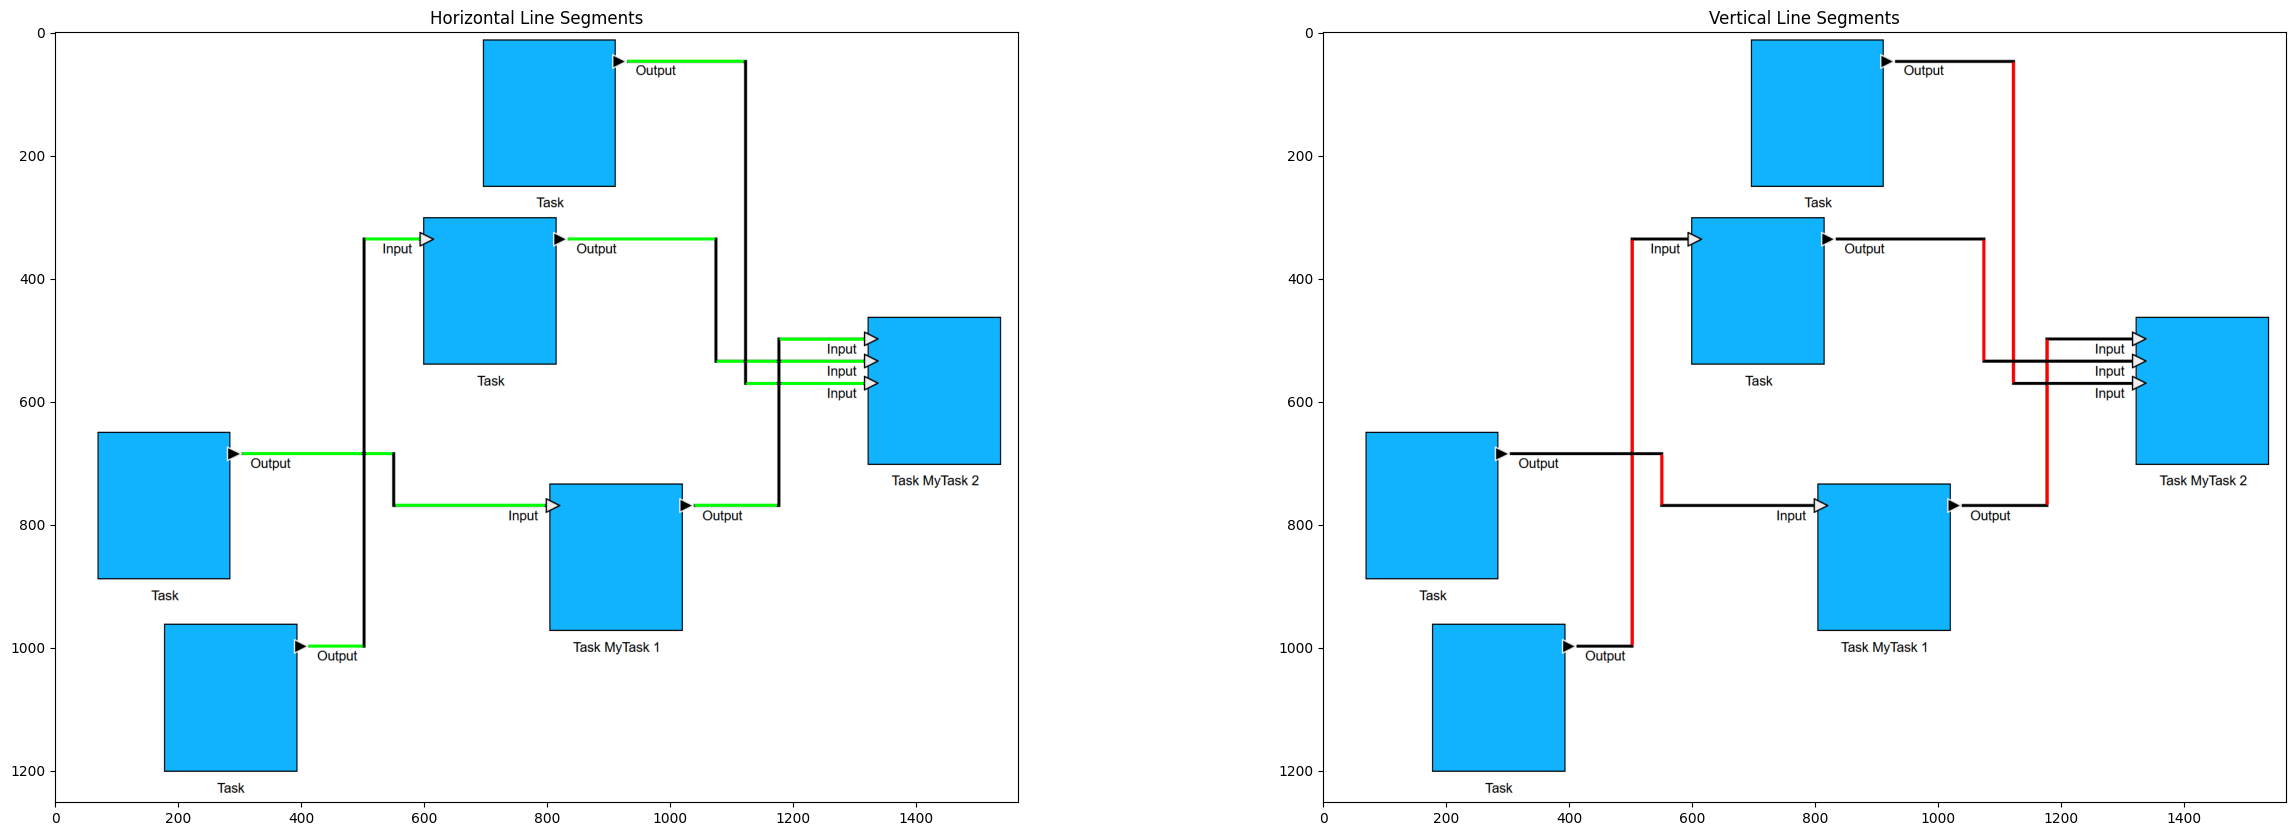

Vertical line segment 0: Start: (502, 689), End: (502, 995)
Vertical line segment 1: Start: (550, 688), End: (550, 767)
Vertical line segment 2: Start: (1176, 575), End: (1176, 767)
Vertical line segment 3: Start: (1176, 539), End: (1176, 567)
Vertical line segment 4: Start: (1121, 539), End: (1121, 568)
Vertical line segment 5: Start: (1176, 501), End: (1176, 531)
Vertical line segment 6: Start: (1073, 339), End: (1073, 532)
Vertical line segment 7: Start: (502, 339), End: (502, 681)
Vertical line segment 8: Start: (1121, 50), End: (1121, 531)


In [691]:
# Draw the horizontal lines
edges_hor_img = target_img.copy()
for line in line_segments_hor:
    cv2.line(edges_hor_img, line[0], line[1], (0, 255, 0), 4)

# Draw the vertical lines
edges_ver_img = target_img.copy()
for line in line_segments_ver:
    cv2.line(edges_ver_img, line[0], line[1], (0, 0, 255), 4)

# Create a single figure with two subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize=(30, 10))

# Plot the horizontal lines in the first subplot
ax[0].imshow(cv2.cvtColor(edges_hor_img, cv2.COLOR_BGR2RGB))
ax[0].set_title('Horizontal Line Segments')

# Plot the vertical lines in the second subplot
ax[1].imshow(cv2.cvtColor(edges_ver_img, cv2.COLOR_BGR2RGB))
ax[1].set_title('Vertical Line Segments')
print(line_segments_hor)
plt.show()
for i, line in enumerate(line_segments_ver):
    print(f"Vertical line segment {i}: Start: ({line[0][0]}, {line[0][1]}), End: ({line[1][0]}, {line[1][1]})")


#### Visualize Horizontal and Vertical Line Segments Highlighting the Points

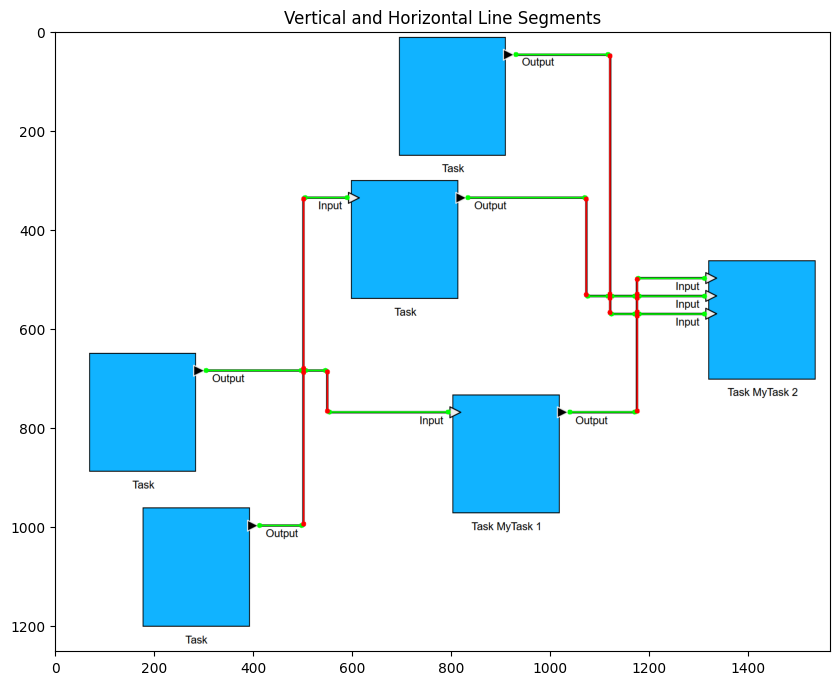

In [692]:
# Draw the vertical and horizontal line segments over the target image. Highlight the starting and ending points of the line segments with circles.
edges_img = target_img.copy()
for line in line_segments_hor:
    cv2.line(edges_img, line[0], line[1], (0, 255, 0), 2)
    cv2.circle(edges_img, line[0], 5, (0, 255, 0), -1)
    cv2.circle(edges_img, line[1], 5, (0, 255, 0), -1)
for line in line_segments_ver:
    cv2.line(edges_img, line[0], line[1], (0, 0, 255), 2)
    cv2.circle(edges_img, line[0], 5, (0, 0, 255), -1)
    cv2.circle(edges_img, line[1], 5, (0, 0, 255), -1)

# Plot the vertical and horizontal lines
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(cv2.cvtColor(edges_img, cv2.COLOR_BGR2RGB))
ax.set_title('Vertical and Horizontal Line Segments')
plt.show()


## From Line Segments to Polygonal Chain
I do not only want line segments. I want to have connected line segments which form a polygonal chain. The problem however is that the line segments do not touch each other. There's a small gap.
Concept: chain the segments together. Currently only supports horizontally starting signals. This is always the case for the Functions Layer, but needs to be expanded in future. 


#### Sort segments

In [693]:
# Sort horizontal segments from left to right and vertical segments from top to bottom
# Separated vertical and horizontal segments
line_segments_hor_sorted = line_segments_hor.copy()
line_segments_hor_sorted.sort(key=lambda seg: (seg[0][0], seg[0][1]))
line_segments_ver_sorted = line_segments_ver.copy()
line_segments_ver_sorted.sort(key=lambda seg: (seg[0][1], seg[0][0]))

# Print the sorted horizontal and vertical segments
print(f"Sorted Horizontal Segments: {line_segments_hor_sorted}")
print(f"Sorted Vertical Segments: {line_segments_ver_sorted}")


Sorted Horizontal Segments: [((np.int32(305), np.int64(685)), (np.int32(497), np.int64(685))), ((np.int32(413), np.int64(998)), (np.int32(498), np.int64(998))), ((np.int32(505), np.int64(336)), (np.int32(590), np.int64(336))), ((np.int32(506), np.int64(685)), (np.int32(546), np.int64(685))), ((np.int32(554), np.int64(769)), (np.int32(794), np.int64(769))), ((np.int32(834), np.int64(336)), (np.int32(1070), np.int64(336))), ((np.int32(931), np.int64(47)), (np.int32(1117), np.int64(47))), ((np.int32(1040), np.int64(769)), (np.int32(1171), np.int64(769))), ((np.int32(1076), np.int64(535)), (np.int32(1117), np.int64(535))), ((np.int32(1124), np.int64(571)), (np.int32(1171), np.int64(571))), ((np.int32(1125), np.int64(535)), (np.int32(1171), np.int64(535))), ((np.int32(1178), np.int64(499)), (np.int32(1312), np.int64(499))), ((np.int32(1180), np.int64(535)), (np.int32(1312), np.int64(535))), ((np.int32(1180), np.int64(571)), (np.int32(1312), np.int64(571)))]
Sorted Vertical Segments: [((np.i

#### Visualize Sorted Segments

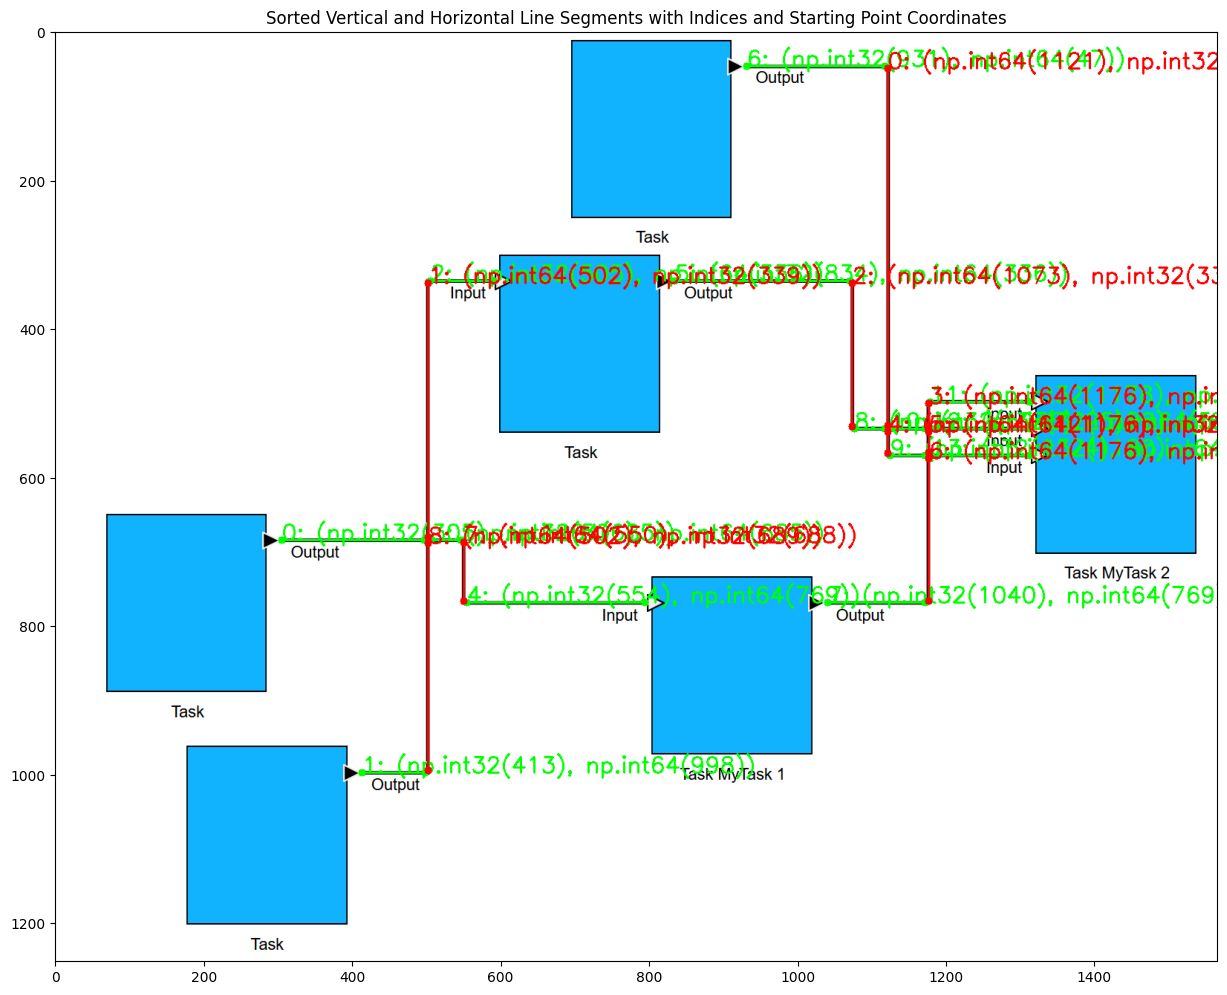

Number of horizontal segments: 14
Number of vertical segments: 9


In [694]:
# plot the sorted horizontal and vertical segments again, now with their indices
# Draw the vertical and horizontal line segments over the target image. Highlight the starting and ending points of the line segments with circles.
edges_img_sorted = target_img.copy()
for i, line in enumerate(line_segments_hor_sorted):
    cv2.line(edges_img_sorted, line[0], line[1], (0, 255, 0), 2)
    cv2.circle(edges_img_sorted, line[0], 5, (0, 255, 0), -1)
    cv2.circle(edges_img_sorted, line[1], 5, (0, 255, 0), -1)
    start_coords_text = f"{i}: {line[0]}"
    cv2.putText(edges_img_sorted, start_coords_text, line[0], cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
for i, line in enumerate(line_segments_ver_sorted):
    cv2.line(edges_img_sorted, line[0], line[1], (0, 0, 255), 2)
    cv2.circle(edges_img_sorted, line[0], 5, (0, 0, 255), -1)
    cv2.circle(edges_img_sorted, line[1], 5, (0, 0, 255), -1)
    start_coords_text = f"{i}: {line[0]}"
    cv2.putText(edges_img_sorted, start_coords_text, line[0], cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

# Plot the vertical and horizontal lines
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(cv2.cvtColor(edges_img_sorted, cv2.COLOR_BGR2RGB))
ax.set_title('Sorted Vertical and Horizontal Line Segments with Indices and Starting Point Coordinates')
plt.show()

print(f"Number of horizontal segments: {len(line_segments_hor_sorted)}")
print(f"Number of vertical segments: {len(line_segments_ver_sorted)}")


## Chain the line segments together
It starts with the leftest horizontal line segment and walks its way to the end of the edge what the polygonal chain. Currently this does not support starting with a vertical line segment. This needs to be generalized in future. For example it might use some heuristics to check that it is not an intermediate line segment, but a starting or ending line segment of a chain.

Take the leftest horizontal segment. Search for closest starting/ending points of vertical segment. Store, which segments are used. Continue alternativ vertical/horizontal. Finish polygonal chain if no starting/ending point within a distance of 7.

Well explained in PowerPoint slides.

### finding crossings

In [695]:
# finding crosses

template_image_path = 'cross_kernel.png'
template_img = cv2.imread(template_image_path)
res = cv2.matchTemplate(target_img, template_img, cv2.TM_CCOEFF_NORMED)

# Threshold the result
threshold = 0.95 # 0.92 or lower results in multiple matches per crossing
loc = np.where(res >= threshold)

# Set all values below the threshold to 0
thresholded_res = np.copy(res)
thresholded_res[thresholded_res < threshold] = 0

# Move the detected crosses 6 pixels to the right and 6 pixels down
loc = (loc[0] + 6, loc[1] + 6)

print(f"Found {len(loc[0])} matches with a threshold of {threshold}")

for i in range(len(loc[0])):
    print(f"Crossing at ({loc[1][i]}, {loc[0][i]})")


Found 4 matches with a threshold of 0.95
Crossing at (1122, 535)
Crossing at (1176, 535)
Crossing at (1176, 571)
Crossing at (502, 686)


#### Processing crossings
If multiple crossings are detected in close proximity, only the top left one is added. All crossings are saved in a list 'crossings'

Not really neccesary if threshold is above 0.92

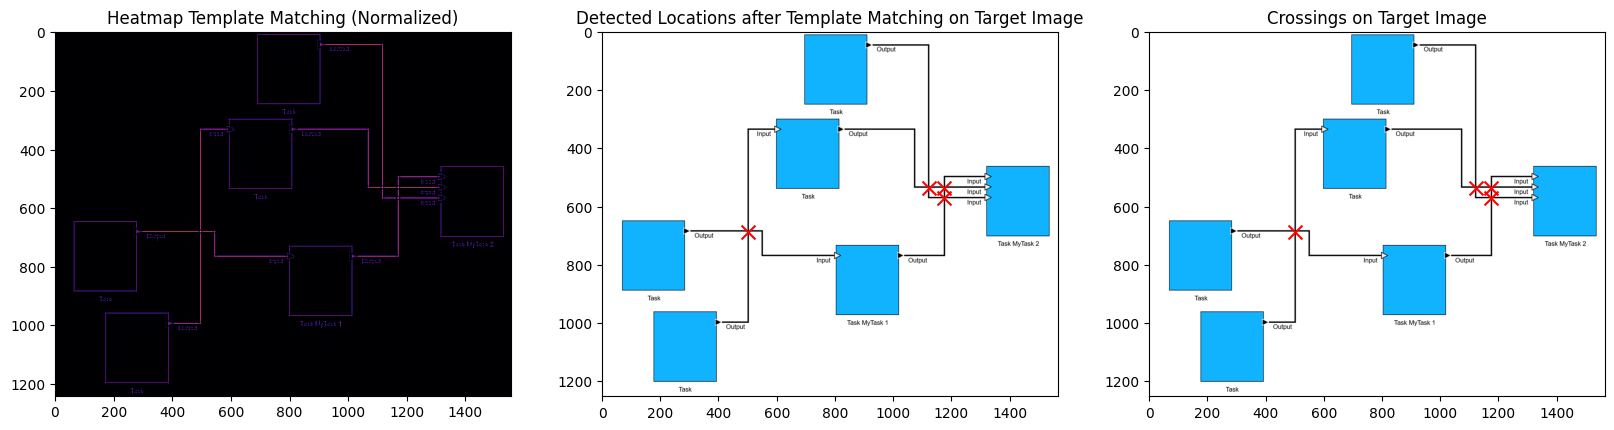

In [696]:
def calculate_distance(point1, point2):
    """Calculate the Euclidean distance between two points."""
    return ((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2) ** 0.5

# Combine the detected points into a list of tuples
detected_points = list(zip(loc[1], loc[0]))

# Sort the points by their coordinates (top-left first)
detected_points.sort()

# Filter out points that are very close to each other
crossings = []
min_distance = 5  # Minimum distance to consider points as separate

for point in detected_points:
    if not crossings or all(calculate_distance(point, existing_point) > min_distance for existing_point in crossings):
        crossings.append(point)

# Draw the result of the template matching, normalized -> comparable
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(res, cmap='inferno', vmin=0, vmax=1)
ax[0].set_title('Heatmap Template Matching (Normalized)')

# draw the loc as points
ax[1].imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
ax[1].scatter(loc[1], loc[0], c='r', s=100, marker='x')
ax[1].set_title(f'Detected Locations after Template Matching on Target Image')

# Draw the crossings on the target image
ax[2].imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
for crossing in crossings:
    ax[2].scatter(crossing[0], crossing[1], c='r', s=100, marker='x')
ax[2].set_title('Crossings on Target Image')

plt.show()

#### connecting intersections

In [697]:
def find_closest_lines(crossing, line_segments_ver_sorted, line_segments_hor_sorted):
    x, y = crossing
    closest_ver = sorted(line_segments_ver_sorted, key=lambda seg: min(abs(seg[0][0] - x), abs(seg[1][0] - x)))[:2]
    closest_hor = sorted(line_segments_hor_sorted, key=lambda seg: min(abs(seg[0][1] - y), abs(seg[1][1] - y)))[:2]
    return closest_ver, closest_hor

def merge_lines(closest_ver, closest_hor):
    merged_ver = (min(closest_ver[0][0][1], closest_ver[1][0][1]), max(closest_ver[0][1][1], closest_ver[1][1][1]))
    merged_hor = (min(closest_hor[0][0][0], closest_hor[1][0][0]), max(closest_hor[0][1][0], closest_hor[1][1][0]))
    return merged_ver, merged_hor

def connect_lines_at_crossings(crossings, line_segments_ver_sorted, line_segments_hor_sorted):
    merged_lines = []
    for crossing in crossings:
        closest_ver, closest_hor = find_closest_lines(crossing, line_segments_ver_sorted, line_segments_hor_sorted)
        
        merged_ver, merged_hor = merge_lines(closest_ver, closest_hor)
        
        for line in closest_ver:
            line_segments_ver_sorted.remove(line)
        for line in closest_hor:
            line_segments_hor_sorted.remove(line)
        
        new_ver_line = ((crossing[0], merged_ver[0]), (crossing[0], merged_ver[1]))
        new_hor_line = ((merged_hor[0], crossing[1]), (merged_hor[1], crossing[1]))
        
        line_segments_ver_sorted.append(new_ver_line)
        line_segments_hor_sorted.append(new_hor_line)
        
        merged_lines.append((new_ver_line, new_hor_line))
    
    return line_segments_ver_sorted, line_segments_hor_sorted, merged_lines

visualize the merged lines

Intersection 1:
  Vertical Line: ((np.int64(502), np.int32(339)), (np.int64(502), np.int32(995)))
  Horizontal Line: ((np.int32(305), np.int64(686)), (np.int32(546), np.int64(686)))

Intersection 2:
  Vertical Line: ((np.int64(1122), np.int32(50)), (np.int64(1122), np.int32(568)))
  Horizontal Line: ((np.int32(1076), np.int64(535)), (np.int32(1171), np.int64(535)))

Intersection 3:
  Vertical Line: ((np.int64(1176), np.int32(501)), (np.int64(1176), np.int32(567)))
  Horizontal Line: ((np.int32(1076), np.int64(535)), (np.int32(1312), np.int64(535)))

Intersection 4:
  Vertical Line: ((np.int64(1176), np.int32(501)), (np.int64(1176), np.int32(767)))
  Horizontal Line: ((np.int32(1124), np.int64(571)), (np.int32(1312), np.int64(571)))



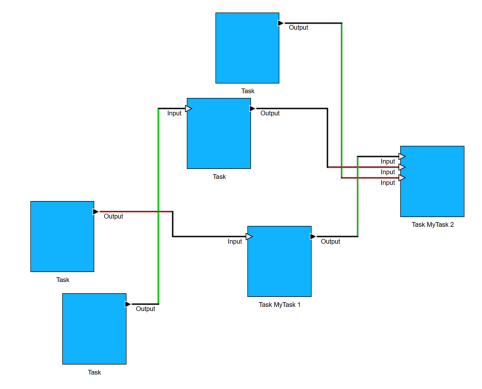

In [698]:
def print_merged_lines(merged_lines):
    for i, (ver_line, hor_line) in enumerate(merged_lines):
        print(f"Intersection {i+1}:")
        print(f"  Vertical Line: {ver_line}")
        print(f"  Horizontal Line: {hor_line}")
        print()

def draw_lines_on_image(img, merged_lines):
    for ver_line, hor_line in merged_lines:
        cv2.line(img, ver_line[0], ver_line[1], (0, 255, 0), 2)
        cv2.line(img, hor_line[0], hor_line[1], (0, 0, 255), 2)
    return img

line_segments_ver_sorted, line_segments_hor_sorted, merged_lines = connect_lines_at_crossings(crossings, line_segments_ver_sorted, line_segments_hor_sorted)

print_merged_lines(merged_lines)

target_img_with_lines = draw_lines_on_image(target_img.copy(), merged_lines)

# Display the image with lines
plt.imshow(cv2.cvtColor(target_img_with_lines, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

Now the connected line segments have to be merged with the rest of the detected lines

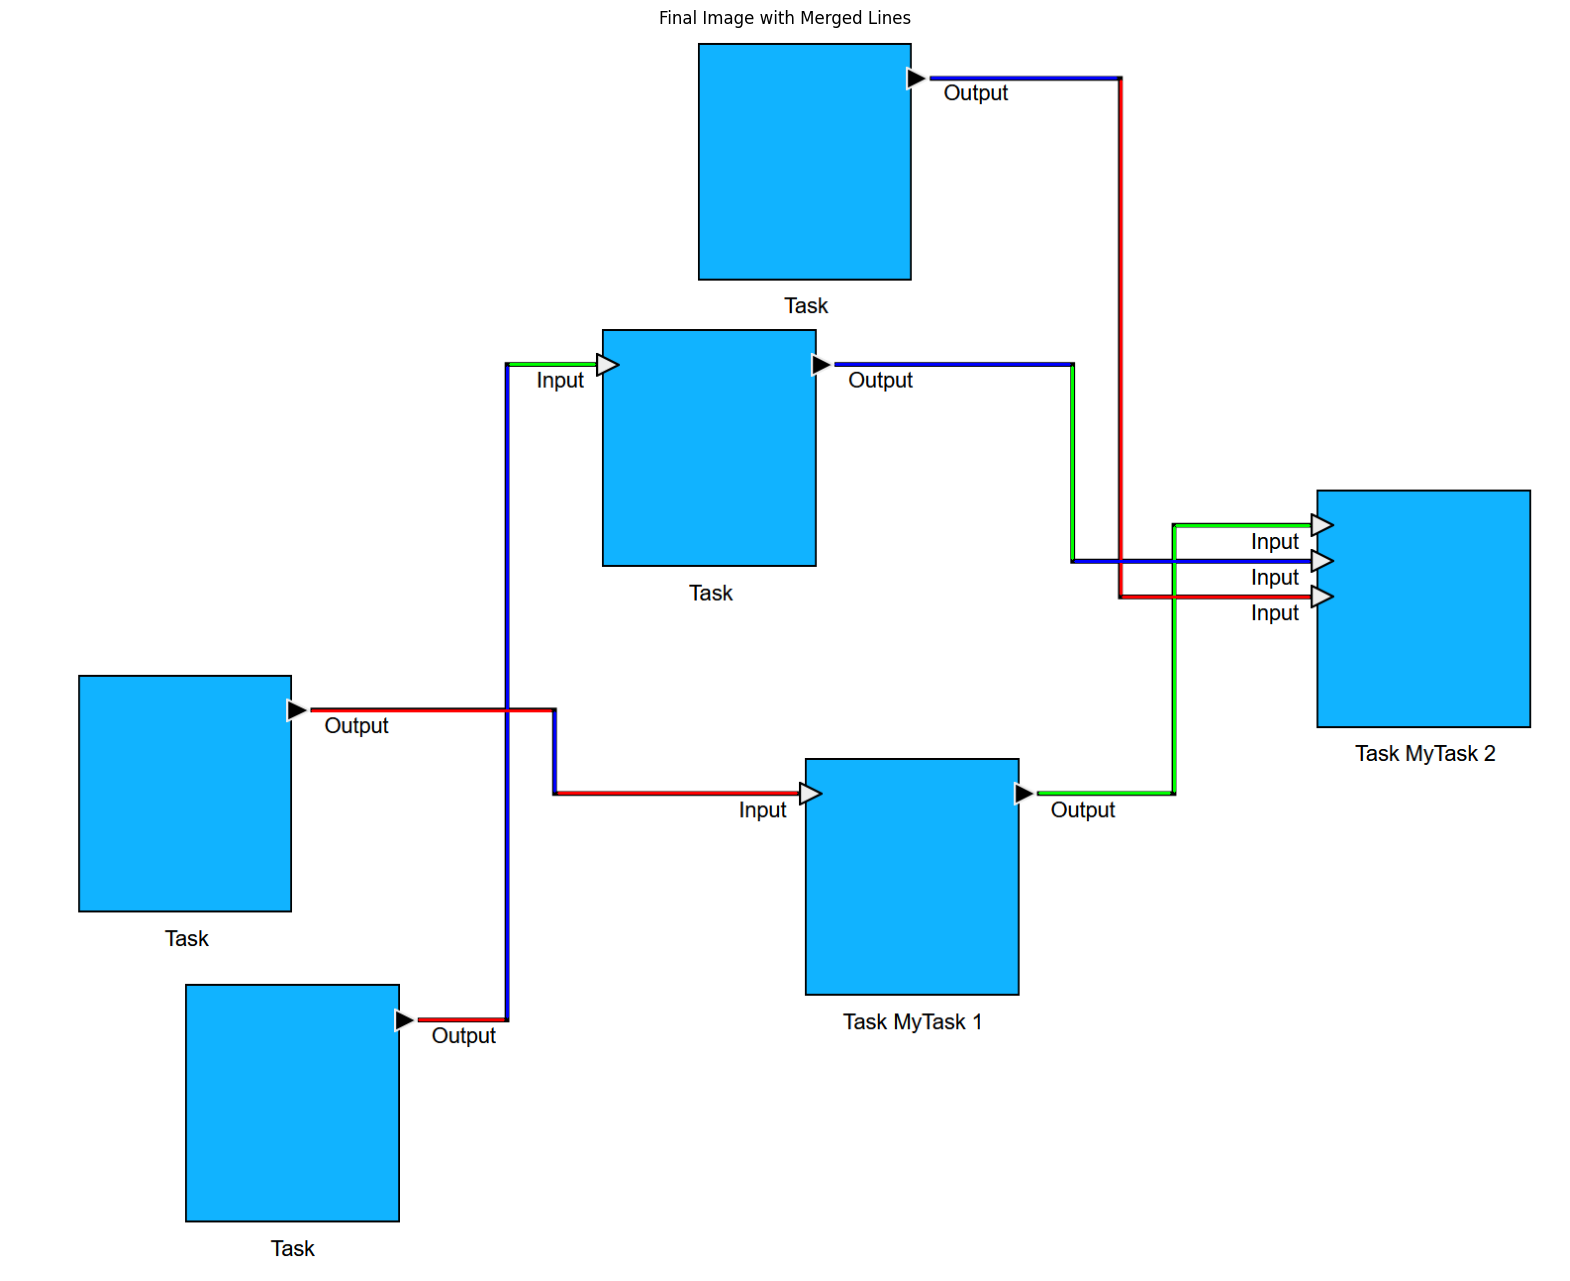

((413, 998), (498, 998))
((505, 336), (590, 336))
((554, 769), (794, 769))
((834, 336), (1070, 336))
((931, 47), (1117, 47))
((1040, 769), (1171, 769))
((1178, 499), (1312, 499))
((305, 686), (546, 686))
((1076, 535), (1312, 535))
((1124, 571), (1312, 571))
((1073, 339), (1073, 532))
((550, 688), (550, 767))
((502, 339), (502, 995))
((1122, 50), (1122, 568))
((1176, 501), (1176, 767))
Total number of lines: 15


In [699]:
final_img = target_img.copy()
# Merge the merged_lines with the remaining line segments
for ver_line, hor_line in merged_lines:
    if ver_line in line_segments_ver_sorted:
        line_segments_ver_sorted.remove(ver_line)
    if hor_line in line_segments_hor_sorted:
        line_segments_hor_sorted.remove(hor_line)
    line_segments_ver_sorted.append(ver_line)
    line_segments_hor_sorted.append(hor_line)

# Draw the merged lines on the image with different colors
def are_lines_overlapping(line1, line2, threshold=3):
    """Check if two lines are overlapping within a given threshold."""
    (x1, y1), (x2, y2) = line1
    (x3, y3), (x4, y4) = line2
    
    # Check if lines are vertical
    if x1 == x2 == x3 == x4:
        return abs(y1 - y3) <= threshold or abs(y2 - y4) <= threshold
    # Check if lines are horizontal
    elif y1 == y2 == y3 == y4:
        return abs(x1 - x3) <= threshold or abs(x2 - x4) <= threshold
    return False

def remove_overlapping_lines(lines):
    """Remove shorter overlapping lines from the list."""
    non_overlapping_lines = []
    for i, line1 in enumerate(lines):
        overlap_found = False
        for j, line2 in enumerate(lines):
            if i != j and are_lines_overlapping(line1, line2):
                if cv2.norm(np.array(line1[0]) - np.array(line1[1])) < cv2.norm(np.array(line2[0]) - np.array(line2[1])):
                    overlap_found = True
                    break
        if not overlap_found:
            non_overlapping_lines.append(line1)
    return non_overlapping_lines

# Remove overlapping lines
line_segments_ver_sorted = remove_overlapping_lines(line_segments_ver_sorted)
line_segments_hor_sorted = remove_overlapping_lines(line_segments_hor_sorted)

colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]  # Red, Green, Blue
for i, line in enumerate(line_segments_ver_sorted):
    color = colors[i % len(colors)]
    color = random.choice(colors)
    cv2.line(final_img, line[0], line[1], color, 2)
for i, line in enumerate(line_segments_hor_sorted):
    color = random.choice(colors)
    cv2.line(final_img, line[0], line[1], color, 2)


# Display the final image with all lines
plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))
plt.title('Final Image with Merged Lines')
plt.axis('off')
plt.show()

# Print all lines in line_segments_hor and line_segments_ver in a list
# Convert numpy integer types to regular Python integers for printing
all_lines = [(tuple(map(int, line[0])), tuple(map(int, line[1]))) for line in line_segments_hor_sorted + line_segments_ver_sorted]
for line in all_lines:
    print(line)

# Print the total number of lines
print(f'Total number of lines: {len(all_lines)}')

In [700]:
def find_closest_segment(base_segment, candidate_segments, max_distance=7):
    """Find the closest segment from candidate_segments to either the start or end point of the base_segment. But only to a maximum distance of max_distance."""
    closest_segment = None
    closest_distance = max_distance + 1  # Initialize with a value slightly larger than max_distance

    # Check both the start and end points of the base segment
    for base_point in [base_segment[0], base_segment[1]]:
        for seg in candidate_segments:
            # Check both start and end points of the candidate segment
            for point in [seg[0], seg[1]]:
                distance = calculate_distance(base_point, point)
                if distance < closest_distance:
                    closest_distance = distance
                    closest_segment = seg

    return closest_segment if closest_distance <= max_distance else None


def group_segments_into_chains(all_segments, max_distance=7):
    chains = []
    used_segments = set()

    # Function to add segments to 'used_segments' and remove them from 'all_segments'
    def mark_used(seg):
        if seg in all_segments:
            all_segments.remove(seg)
        used_segments.add(seg)

    # Start with any segment as potential starting points
    for seg in list(all_segments):  # Use list(...) to avoid modifying the list while iterating
        print(f"Processing segment: {seg}")
        if seg in used_segments:
            print("Already used. Skipping.")
            continue
        current_chain = [seg]  # chain starts with the current segment
        print(f"Starting chain with: {seg}")
        mark_used(seg)

        # Alternate between finding the next closest segment to connect
        while True:
            next_seg = find_closest_segment(current_chain[-1], all_segments, max_distance)
            print(f"Next segment: {next_seg}")
            if next_seg:
                current_chain.append(next_seg)
                mark_used(next_seg)
            else:
                print("No further segment found. This chain is complete.\n")
                break

        chains.append(current_chain)

    return chains

line_segment_chains = group_segments_into_chains(all_lines.copy())


Processing segment: ((413, 998), (498, 998))
Starting chain with: ((413, 998), (498, 998))
Next segment: ((502, 339), (502, 995))
Next segment: ((505, 336), (590, 336))
Next segment: None
No further segment found. This chain is complete.

Processing segment: ((505, 336), (590, 336))
Already used. Skipping.
Processing segment: ((554, 769), (794, 769))
Starting chain with: ((554, 769), (794, 769))
Next segment: ((550, 688), (550, 767))
Next segment: ((305, 686), (546, 686))
Next segment: None
No further segment found. This chain is complete.

Processing segment: ((834, 336), (1070, 336))
Starting chain with: ((834, 336), (1070, 336))
Next segment: ((1073, 339), (1073, 532))
Next segment: ((1076, 535), (1312, 535))
Next segment: None
No further segment found. This chain is complete.

Processing segment: ((931, 47), (1117, 47))
Starting chain with: ((931, 47), (1117, 47))
Next segment: ((1122, 50), (1122, 568))
Next segment: ((1124, 571), (1312, 571))
Next segment: None
No further segment 

#### Visualize and print the Chains
still sets of line segments with a gap

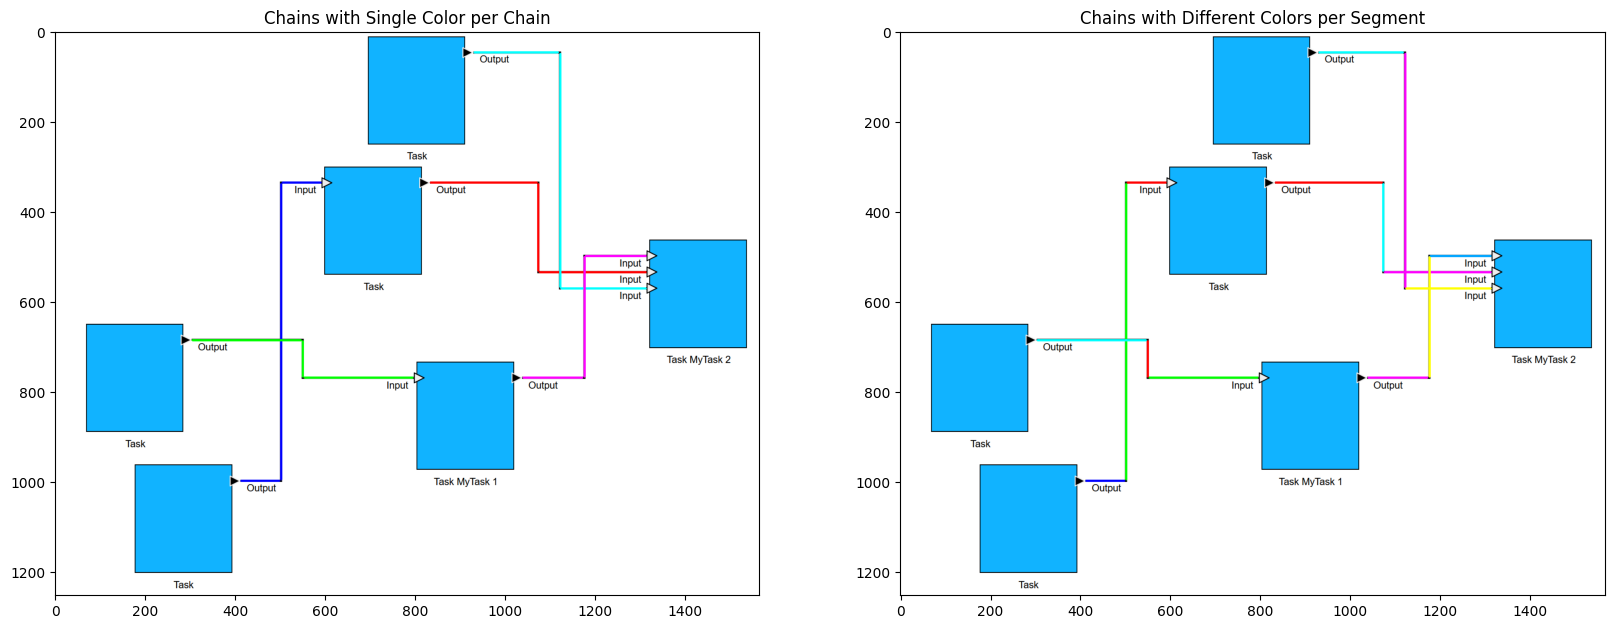

Chain 1:
  Start: (413, 998), End: (498, 998)
  Start: (502, 339), End: (502, 995)
  Start: (505, 336), End: (590, 336)
Chain 2:
  Start: (554, 769), End: (794, 769)
  Start: (550, 688), End: (550, 767)
  Start: (305, 686), End: (546, 686)
Chain 3:
  Start: (834, 336), End: (1070, 336)
  Start: (1073, 339), End: (1073, 532)
  Start: (1076, 535), End: (1312, 535)
Chain 4:
  Start: (931, 47), End: (1117, 47)
  Start: (1122, 50), End: (1122, 568)
  Start: (1124, 571), End: (1312, 571)
Chain 5:
  Start: (1040, 769), End: (1171, 769)
  Start: (1176, 501), End: (1176, 767)
  Start: (1178, 499), End: (1312, 499)


In [701]:
# Draw the chains, using different colors for each chain
chain_img = target_img.copy()
chain_img2 = target_img.copy()
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255), (0, 255, 255), (255, 165, 0), (255, 20, 147), (0, 128, 0), (75, 0, 130), (238, 130, 238), (0, 255, 127), (255, 69, 0)]

for i, chain in enumerate(line_segment_chains):
    color = colors[i % len(colors)]
    for start, end in chain:
        cv2.line(chain_img, start, end, color, 4)

for i, chain in enumerate(line_segment_chains):
    for j, (start, end) in enumerate(chain):
        color = colors[(i + j) % len(colors)]
        cv2.line(chain_img2, start, end, color, 4)

# Plot the chains side by side
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(cv2.cvtColor(chain_img, cv2.COLOR_BGR2RGB))
ax[0].set_title('Chains with Single Color per Chain')
ax[1].imshow(cv2.cvtColor(chain_img2, cv2.COLOR_BGR2RGB))
ax[1].set_title('Chains with Different Colors per Segment')
plt.show()

# Print the chains with their coordinates in a neat way, also number them
for i, chain in enumerate(line_segment_chains):
    print(f"Chain {i + 1}:")
    for start, end in chain:
        print(f"  Start: {start}, End: {end}")

The generated chains have gaps between segments, which need to be closed before they can be converted to polylines

In [702]:
# def extend_line_to_intersect(line1, line2):
#     """
#     Extend two lines so they intersect perfectly.
#     """
#     (x1, y1), (x2, y2) = line1
#     (x3, y3), (x4, y4) = line2

#     # Calculate the intersection point
#     denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
#     if denom == 0:
#         return None  # Lines are parallel

#     intersect_x = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denom
#     intersect_y = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denom

#     # Extend the lines to the intersection point
#     extended_line1 = ((x1, y1), (int(intersect_x), int(intersect_y)))
#     extended_line2 = ((x3, y3), (int(intersect_x), int(intersect_y)))

#     return extended_line1, extended_line2

# def create_polylines_from_chains(chains):
#     """
#     Create polylines from chains of line segments.
#     """
#     polylines = []
#     for chain in chains:
#         polyline = []
#         for i in range(len(chain) - 1):
#             line1 = chain[i]
#             line2 = chain[i + 1]
#             extended_line1, extended_line2 = extend_line_to_intersect(line1, line2)
#             if extended_line1 and extended_line2:
#                 polyline.append(extended_line1[0])
#                 polyline.append(extended_line1[1])
#         if chain:
#             polyline.append(chain[-1][1])  # Ensure the last point of the last segment is included
#         if polyline:
#             polylines.append(polyline)
#     return polylines

# def draw_polylines_on_image(img, polylines):
#     """
#     Draw polylines on the image.
#     """
#     for polyline in polylines:
#         pts = np.array(polyline, np.int32)
#         pts = pts.reshape((-1, 1, 2))
#         cv2.polylines(img, [pts], isClosed=False, color=(0, 255, 0), thickness=2)
#     return img

# # Create polylines from the chains
# polylines = create_polylines_from_chains(line_segment_chains)

# # Draw the polylines on the target image
# target_img_with_polylines = draw_polylines_on_image(target_img.copy(), polylines)

# # Display the image with polylines
# plt.figure(figsize=(10, 10))
# plt.imshow(cv2.cvtColor(target_img_with_polylines, cv2.COLOR_BGR2RGB))
# plt.title('Polylines on Target Image')
# plt.axis('off')
# plt.show()

### From Chains to Polylines

In [708]:
# currently not used
# def calculate_intersection(horizontal_seg, vertical_seg):
#     """Calculate the intersection point of a horizontal and a vertical segment."""
#     # The intersection point's x-coordinate comes from the vertical segment,
#     # and the y-coordinate comes from the horizontal segment.
#     print(f"Calculating intersection between {horizontal_seg} and {vertical_seg}")
#     return (vertical_seg[0][0], horizontal_seg[0][1])

def calculate_intersection(seg1, seg2):
    """
    Calculate the intersection point of two line segments.
    Very generic, does not assume that the segments are orthogonal.

    Parameters:
    - seg1, seg2: The line segments, each represented as a tuple of points ((x1, y1), (x2, y2)).

    Returns:
    - The intersection point (x, y) as a tuple, or None if the segments do not intersect.
    """
    print(f"Calculating intersection between {seg1} and {seg2}")
    # Unpack points
    x1, y1, x2, y2 = seg1[0][0], seg1[0][1], seg1[1][0], seg1[1][1]
    x3, y3, x4, y4 = seg2[0][0], seg2[0][1], seg2[1][0], seg2[1][1]

    # Calculate denominators
    den = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    print(f"Denominator: {den}= ({x1} - {x2}) * ({y3} - {y4}) - ({y1} - {y2}) * ({x3} - {x4})")

    # Check if lines are parallel (denominator = 0)
    if den == 0:
        return None  # Lines are parallel and do not intersect

    # Calculate numerators
    t_num = (x1 - x3) * (y3 - y4) - (y1 - y3) * (x3 - x4)
    print(f"t_num: {t_num}= ({x1} - {x3}) * ({y3} - {y4}) - ({y1} - {y3}) * ({x3} - {x4})")
    # u_num = -((x1 - x2) * (y1 - y3) - (y1 - y2) * (x1 - x3))
    # print(f"u_num: {u_num}= -(({x1} - {x2}) * ({y1} - {y3}) - ({y1} - {y2}) * ({x1} - {x3}))")

    # Calculate the intersection point
    t = t_num / den
    print(f"t: {t} = {t_num} / {den}")
    # u = u_num / den

    intersect_x = x1 + t * (x2 - x1)
    print(f"intersect_x: {intersect_x} = {x1} + {t} * ({x2} - {x1})")
    intersect_y = y1 + t * (y2 - y1)
    print(f"intersect_y: {intersect_y} = {y1} + {t} * ({y2} - {y1})")
    return (intersect_x, intersect_y)

def construct_polylines(chains):
    """
    Constructs polylines from chains of line segments, using intersection points between
    consecutive orthogonal segments to form a continuous path.

    Parameters:
    - chains: A list of chains, where each chain is a list of segments ordered such that
      each segment is orthogonal to the next.

    Returns:
    - A list of polylines, where each polyline is represented as an ordered list of points.
    """
    polylines = []

    for chain in chains:
        if not chain:
            continue  # Skip empty chains

        # Start the polyline with the start point of the first segment
        polyline = [chain[0][0]]

        for i in range(len(chain) - 1):
            # Calculate the intersection point between the current segment and the next
            intersection = calculate_intersection(chain[i], chain[i + 1])
            polyline.append(intersection)

        # Add the end point of the last segment in the chain
        polyline.append(chain[-1][1])

        polylines.append(polyline)

    return polylines

polylines = construct_polylines(line_segment_chains)

Chain before conversion:
((413, 998), (498, 998))
((502, 339), (502, 995))
((505, 336), (590, 336))
Calculating intersection between ((413, 998), (498, 998)) and ((502, 339), (502, 995))
Denominator: 55760= (413 - 498) * (339 - 995) - (998 - 998) * (502 - 502)
t_num: 58384= (413 - 502) * (339 - 995) - (998 - 339) * (502 - 502)
t: 1.0470588235294118 = 58384 / 55760
intersect_x: 502.0 = 413 + 1.0470588235294118 * (498 - 413)
intersect_y: 998.0 = 998 + 1.0470588235294118 * (998 - 998)
Calculating intersection between ((502, 339), (502, 995)) and ((505, 336), (590, 336))
Denominator: -55760= (502 - 502) * (336 - 336) - (339 - 995) * (505 - 590)
t_num: 255= (502 - 505) * (336 - 336) - (339 - 336) * (505 - 590)
t: -0.004573170731707317 = 255 / -55760
intersect_x: 502.0 = 502 + -0.004573170731707317 * (502 - 502)
intersect_y: 336.0 = 339 + -0.004573170731707317 * (995 - 339)
Polyline after conversion:
(413, 998)
(502.0, 998.0)
(502.0, 336.0)
(590, 336)
Chain before conversion:
((554, 769), (7

#### Print the polylines

In [704]:
# Printing the constructed polylines
for i, polyline in enumerate(polylines):
    print(f"Polyline {i}: {polyline}")

Polyline 0: [(413, 998), (502.0, 998.0), (502.0, 336.0), (590, 336)]
Polyline 1: [(554, 769), (550.0, 769.0), (550.0, 686.0), (546, 686)]
Polyline 2: [(834, 336), (1073.0, 336.0), (1073.0, 535.0), (1312, 535)]
Polyline 3: [(931, 47), (1122.0, 47.0), (1122.0, 571.0), (1312, 571)]
Polyline 4: [(1040, 769), (1176.0, 769.0), (1176.0, 499.0), (1312, 499)]


#### Visualize Polylines

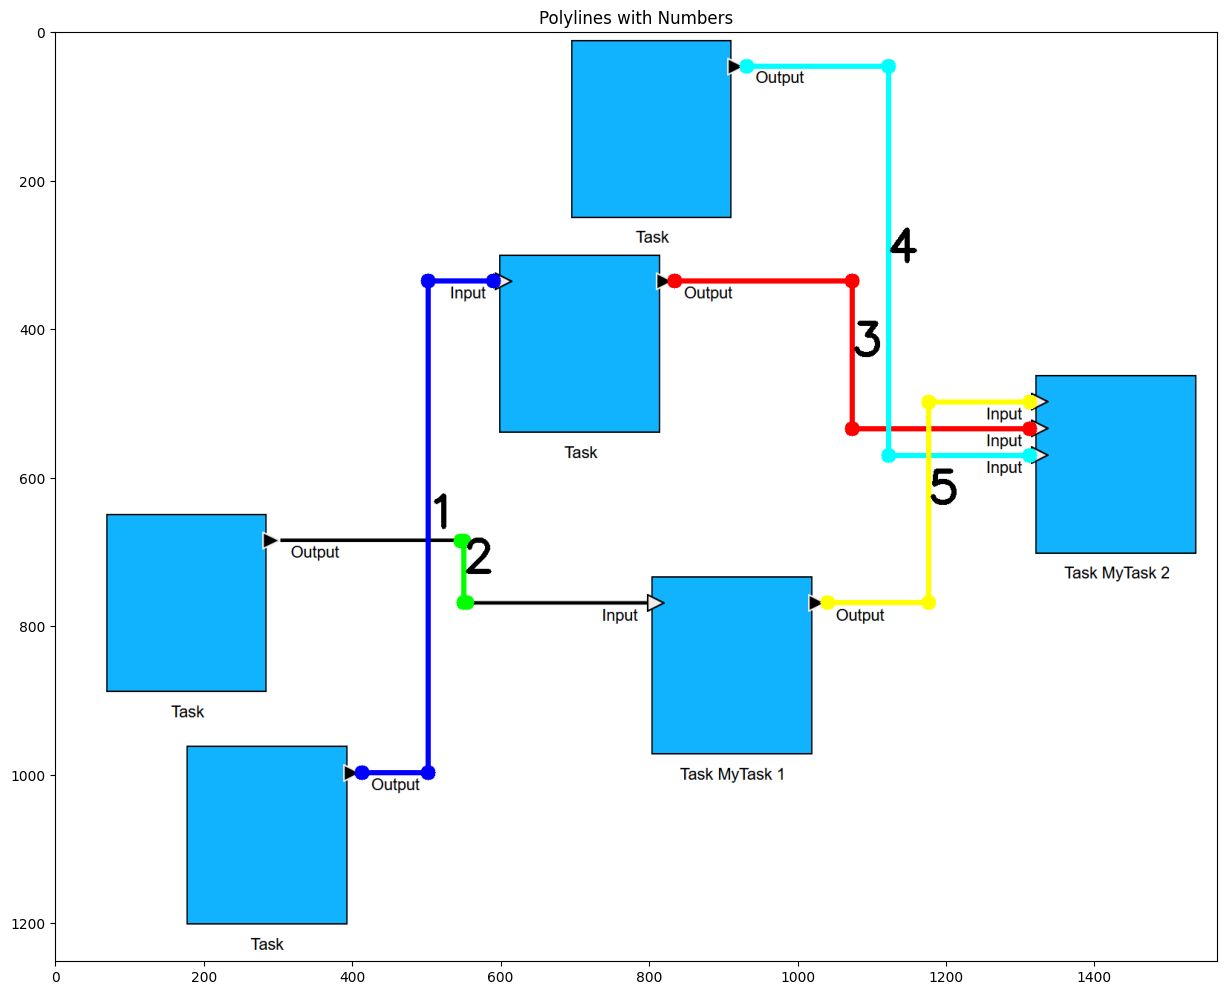

In [706]:

# Filter out None values and convert to integer tuples
filtered_polylines = []
for polyline in polylines:
    filtered_polyline = [point for point in polyline if point is not None]
    filtered_polylines.append(filtered_polyline)

# Convert the polylines to the format expected by OpenCV
opencv_polylines = [np.array(polyline, dtype=np.int32).reshape((-1, 1, 2)) for polyline in filtered_polylines]

# Define colors for the polylines
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255)]

# Draw the polylines
polyline_img = target_img.copy()
for i, polyline in enumerate(opencv_polylines):
    color = colors[i % len(colors)]
    cv2.polylines(polyline_img, [polyline], isClosed=False, color=color, thickness=6)
    for point in polyline:
        cv2.circle(polyline_img, tuple(point.squeeze()), 10, color, -1)
        # Draw the lines on the target_img.copy()
        target_img_with_polylines = target_img.copy()
        for i, polyline in enumerate(opencv_polylines):
            color = colors[i % len(colors)]
            cv2.polylines(target_img_with_polylines, [polyline], isClosed=False, color=color, thickness=6)
            for point in polyline:
                cv2.circle(target_img_with_polylines, tuple(point.squeeze()), 10, color, -1)

# # Plot the polylines
# fig, ax = plt.subplots(1, 1, figsize=(15, 15))
# ax.imshow(cv2.cvtColor(target_img_with_polylines, cv2.COLOR_BGR2RGB))
# plt.title('Polylines')
# plt.show()

# Print the number of each polyline on the image
for i, polyline in enumerate(opencv_polylines):
    # Calculate the center of the polyline for placing the text
    center_x = int(np.mean(polyline[:, 0, 0]))
    center_y = int(np.mean(polyline[:, 0, 1]))
    cv2.putText(target_img_with_polylines, str(i + 1), (center_x, center_y), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 5)

# Plot the polylines with numbers
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(cv2.cvtColor(target_img_with_polylines, cv2.COLOR_BGR2RGB))
plt.title('Polylines with Numbers')
plt.show()